In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ANATOMÍA PATOLÓGICA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=159.1, y1=102.1
Page 1, Q1, A: Yellow pixels: 154
Page 1, Q1, A: Total non-white pixels: 673
Page 1, Q1, A: Yellow percentage: 22.9%


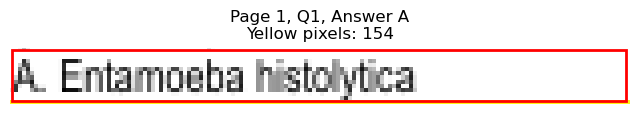

Page 1, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=156.1, y1=114.7
Page 1, Q1, B: Yellow pixels: 1593
Page 1, Q1, B: Total non-white pixels: 1963
Page 1, Q1, B: Yellow percentage: 81.2%


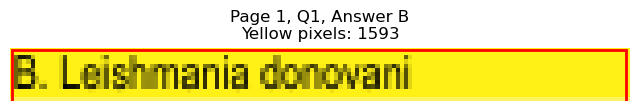

Page 1, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=397.3, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 418
Page 1, Q1, C: Yellow percentage: 0.0%


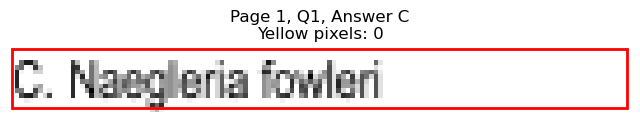

Page 1, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=406.7, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 422
Page 1, Q1, D: Yellow percentage: 0.0%


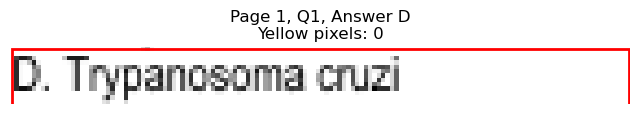


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=181.7, y1=177.8
Page 1, Q2, A: Yellow pixels: 1
Page 1, Q2, A: Total non-white pixels: 751
Page 1, Q2, A: Yellow percentage: 0.1%


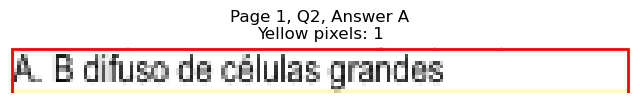

Page 1, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=104.9, y1=190.4
Page 1, Q2, B: Yellow pixels: 1025
Page 1, Q2, B: Total non-white pixels: 1386
Page 1, Q2, B: Yellow percentage: 74.0%


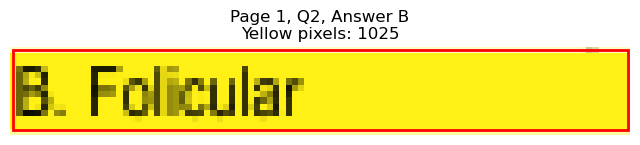

Page 1, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=408.3, y1=177.8
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 425
Page 1, Q2, C: Yellow percentage: 0.0%


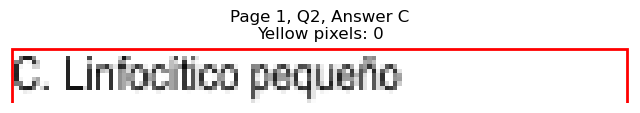

Page 1, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=369.7, y1=190.4
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 242
Page 1, Q2, D: Yellow percentage: 0.0%


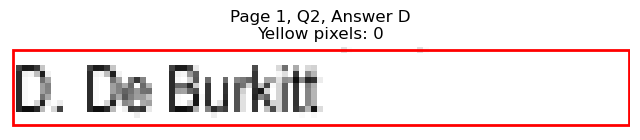


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=133.0, y1=253.5
Page 1, Q3, A: Yellow pixels: 1349
Page 1, Q3, A: Total non-white pixels: 1778
Page 1, Q3, A: Yellow percentage: 75.9%


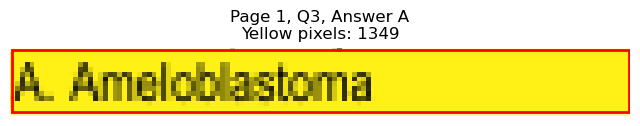

Page 1, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=161.5, y1=266.1
Page 1, Q3, B: Yellow pixels: 156
Page 1, Q3, B: Total non-white pixels: 659
Page 1, Q3, B: Yellow percentage: 23.7%


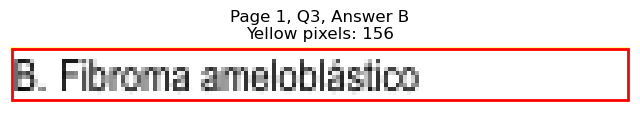

Page 1, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=448.4, y1=253.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 662
Page 1, Q3, C: Yellow percentage: 0.0%


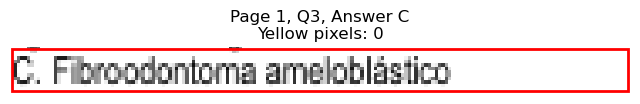

Page 1, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=466.0, y1=266.1
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 724
Page 1, Q3, D: Yellow percentage: 0.0%


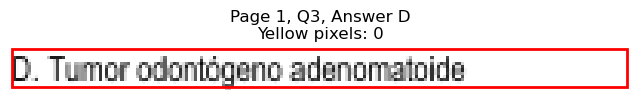


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=126.5, y1=304.0
Page 1, Q4, A: Yellow pixels: 1304
Page 1, Q4, A: Total non-white pixels: 1694
Page 1, Q4, A: Yellow percentage: 77.0%


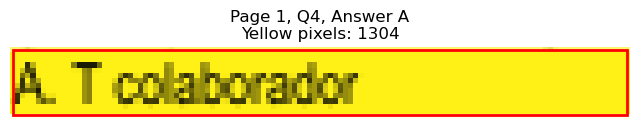

Page 1, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=116.4, y1=316.6
Page 1, Q4, B: Yellow pixels: 111
Page 1, Q4, B: Total non-white pixels: 497
Page 1, Q4, B: Yellow percentage: 22.3%


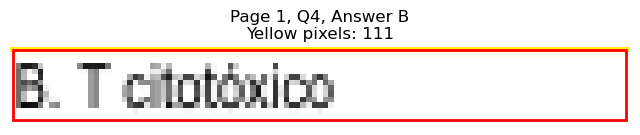

Page 1, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=373.6, y1=304.0
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 253
Page 1, Q4, C: Yellow percentage: 0.0%


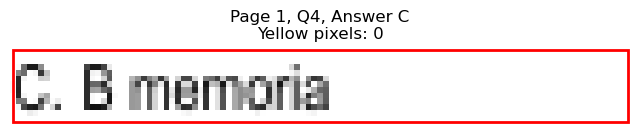

Page 1, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=363.2, y1=316.6
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 201
Page 1, Q4, D: Yellow percentage: 0.0%


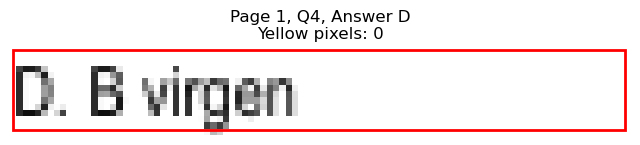


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=151.1, y1=354.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 438
Page 1, Q5, A: Yellow percentage: 0.0%


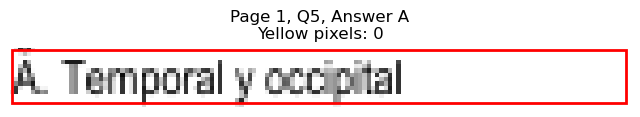

Page 1, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=143.5, y1=367.2
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 431
Page 1, Q5, B: Yellow percentage: 0.0%


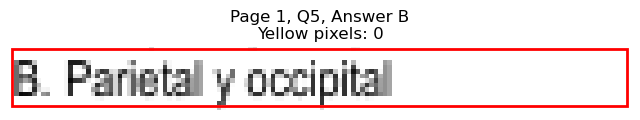

Page 1, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=400.3, y1=354.6
Page 1, Q5, C: Yellow pixels: 136
Page 1, Q5, C: Total non-white pixels: 530
Page 1, Q5, C: Yellow percentage: 25.7%


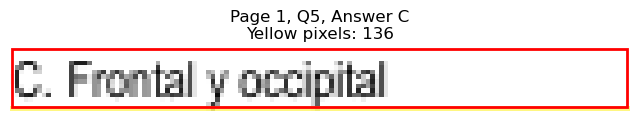

Page 1, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=405.3, y1=367.2
Page 1, Q5, D: Yellow pixels: 1511
Page 1, Q5, D: Total non-white pixels: 1974
Page 1, Q5, D: Yellow percentage: 76.5%


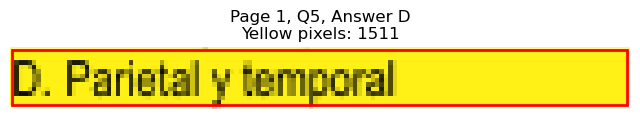


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=189.1, y1=430.3
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 651
Page 1, Q6, A: Yellow percentage: 0.0%


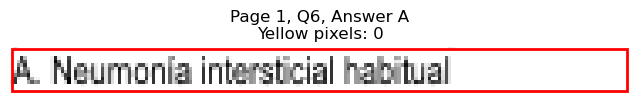

Page 1, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=117.5, y1=442.9
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 301
Page 1, Q6, B: Yellow percentage: 0.0%


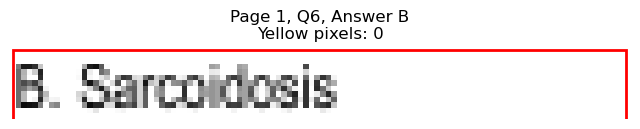

Page 1, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=482.6, y1=430.3
Page 1, Q6, C: Yellow pixels: 1967
Page 1, Q6, C: Total non-white pixels: 3052
Page 1, Q6, C: Yellow percentage: 64.4%


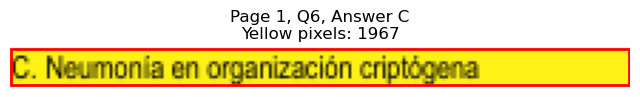

Page 1, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=448.9, y1=442.9
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 842
Page 1, Q6, D: Yellow percentage: 0.0%


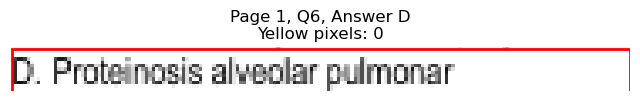


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=144.5, y1=506.0
Page 1, Q7, A: Yellow pixels: 1494
Page 1, Q7, A: Total non-white pixels: 1807
Page 1, Q7, A: Yellow percentage: 82.7%


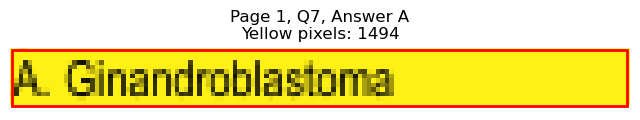

Page 1, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=210.3, y1=518.6
Page 1, Q7, B: Yellow pixels: 205
Page 1, Q7, B: Total non-white pixels: 966
Page 1, Q7, B: Yellow percentage: 21.2%


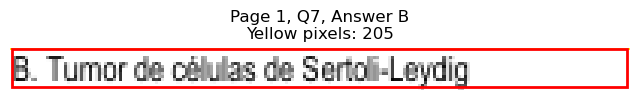

Page 1, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=463.4, y1=506.0
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 697
Page 1, Q7, C: Yellow percentage: 0.0%


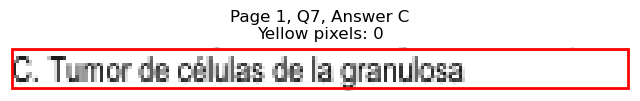

Page 1, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=448.9, y1=518.6
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 645
Page 1, Q7, D: Yellow percentage: 0.0%


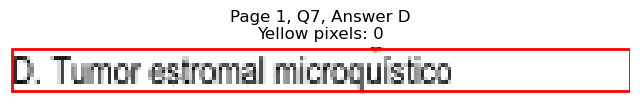


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=148.6, y1=594.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 434
Page 1, Q8, A: Yellow percentage: 0.0%


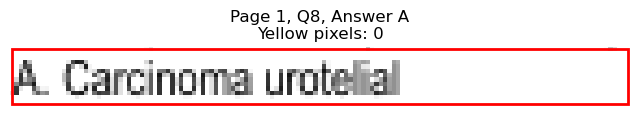

Page 1, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=245.8, y1=606.9
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 930
Page 1, Q8, B: Yellow percentage: 0.0%


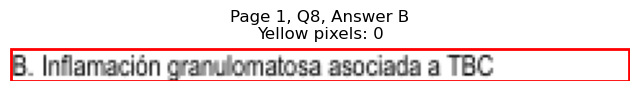

Page 1, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=410.8, y1=594.3
Page 1, Q8, C: Yellow pixels: 146
Page 1, Q8, C: Total non-white pixels: 610
Page 1, Q8, C: Yellow percentage: 23.9%


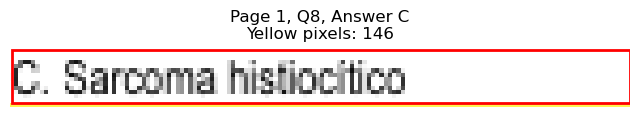

Page 1, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=388.3, y1=606.9
Page 1, Q8, D: Yellow pixels: 1333
Page 1, Q8, D: Total non-white pixels: 1612
Page 1, Q8, D: Yellow percentage: 82.7%


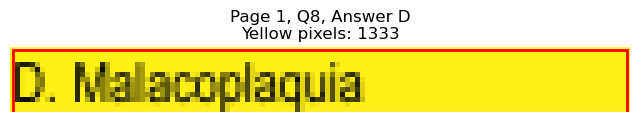


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=221.8, y1=644.9
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 792
Page 1, Q9, A: Yellow percentage: 0.0%


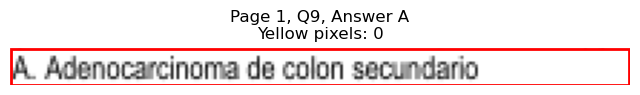

Page 1, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=183.6, y1=657.5
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 591
Page 1, Q9, B: Yellow percentage: 0.0%


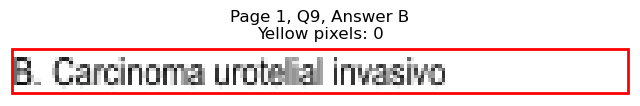

Page 1, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=471.6, y1=644.9
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 960
Page 1, Q9, C: Yellow percentage: 0.0%


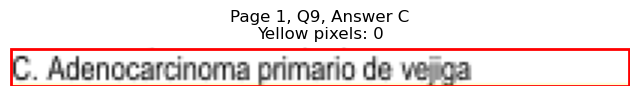

Page 1, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=424.9, y1=657.5
Page 1, Q9, D: Yellow pixels: 1698
Page 1, Q9, D: Total non-white pixels: 2240
Page 1, Q9, D: Yellow percentage: 75.8%


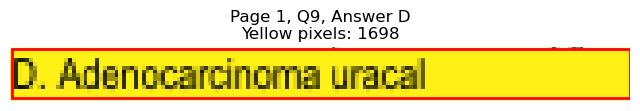


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=174.1, y1=708.0
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 515
Page 1, Q10, A: Yellow percentage: 0.0%


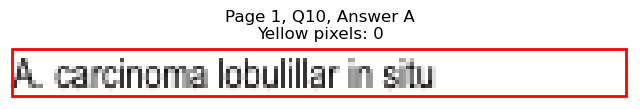

Page 1, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=170.2, y1=720.6
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 568
Page 1, Q10, B: Yellow percentage: 0.0%


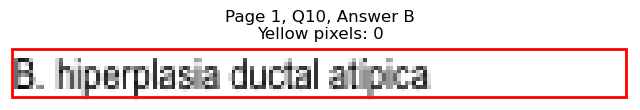

Page 1, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=458.5, y1=708.0
Page 1, Q10, C: Yellow pixels: 1972
Page 1, Q10, C: Total non-white pixels: 2525
Page 1, Q10, C: Yellow percentage: 78.1%


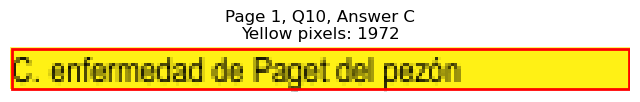

Page 1, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=410.8, y1=720.6
Page 1, Q10, D: Yellow pixels: 141
Page 1, Q10, D: Total non-white pixels: 626
Page 1, Q10, D: Yellow percentage: 22.5%


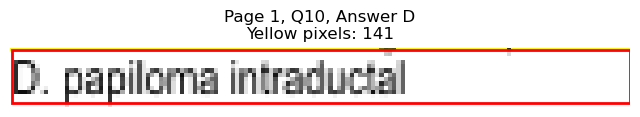


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)
Page 1, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=87.9, y1=758.4
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 131
Page 1, Q11, A: Yellow percentage: 0.0%


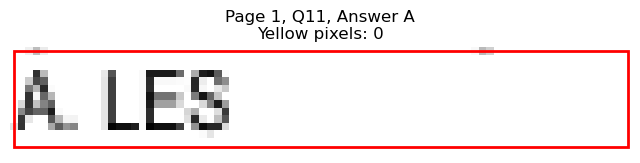

Page 1, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=147.5, y1=771.1
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 443
Page 1, Q11, B: Yellow percentage: 0.0%


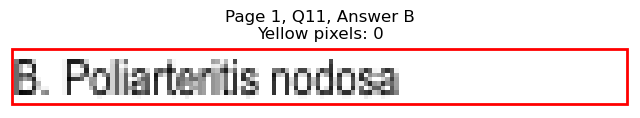

Page 1, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=418.9, y1=758.4
Page 1, Q11, C: Yellow pixels: 0
Page 1, Q11, C: Total non-white pixels: 487
Page 1, Q11, C: Yellow percentage: 0.0%


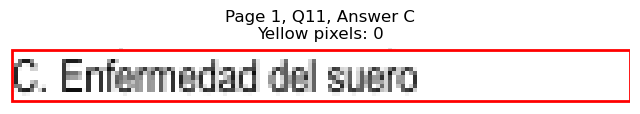

Page 1, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=417.4, y1=771.1
Page 1, Q11, D: Yellow pixels: 1597
Page 1, Q11, D: Total non-white pixels: 2142
Page 1, Q11, D: Yellow percentage: 74.6%


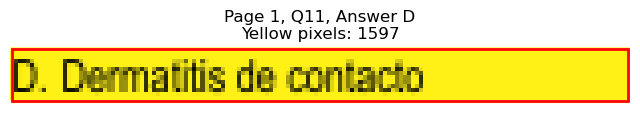


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)

Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=144.0, y1=139.9
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 419
Page 2, Q1, A: Yellow percentage: 0.0%


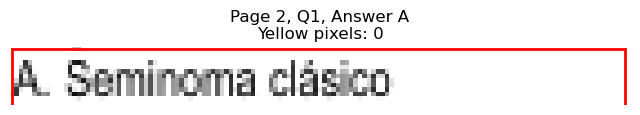

Page 2, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=163.1, y1=152.6
Page 2, Q1, B: Yellow pixels: 1662
Page 2, Q1, B: Total non-white pixels: 2212
Page 2, Q1, B: Yellow percentage: 75.1%


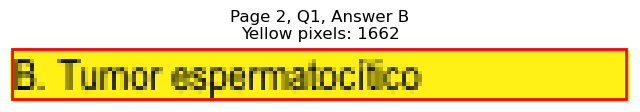

Page 2, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=440.9, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 585
Page 2, Q1, C: Yellow percentage: 0.0%


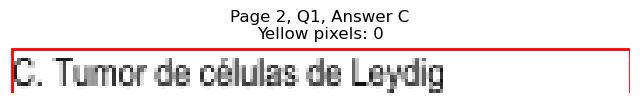

Page 2, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=410.8, y1=152.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 445
Page 2, Q1, D: Yellow percentage: 0.0%


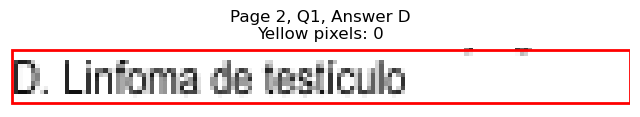


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=152.5, y1=215.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 482
Page 2, Q2, A: Yellow percentage: 0.0%


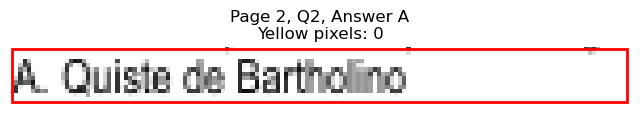

Page 2, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=142.6, y1=228.3
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 405
Page 2, Q2, B: Yellow percentage: 0.0%


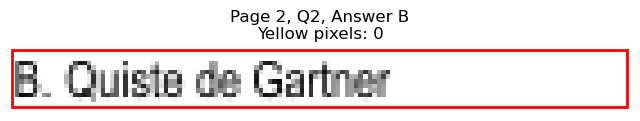

Page 2, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=413.8, y1=215.6
Page 2, Q2, C: Yellow pixels: 1530
Page 2, Q2, C: Total non-white pixels: 2086
Page 2, Q2, C: Yellow percentage: 73.3%


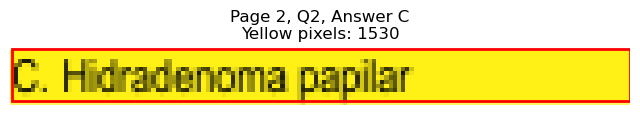

Page 2, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=475.5, y1=228.3
Page 2, Q2, D: Yellow pixels: 211
Page 2, Q2, D: Total non-white pixels: 1009
Page 2, Q2, D: Yellow percentage: 20.9%


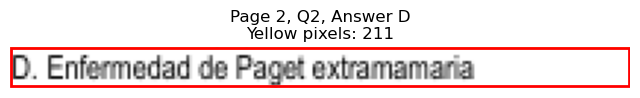


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=189.1, y1=291.4
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 680
Page 2, Q3, A: Yellow percentage: 0.0%


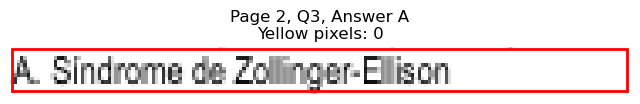

Page 2, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=137.5, y1=304.0
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 413
Page 2, Q3, B: Yellow percentage: 0.0%


Page 2, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=432.3, y1=291.4
Page 2, Q3, C: Yellow pixels: 1720
Page 2, Q3, C: Total non-white pixels: 2352
Page 2, Q3, C: Yellow percentage: 73.1%


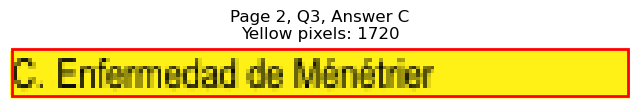

Page 2, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=449.5, y1=304.0
Page 2, Q3, D: Yellow pixels: 185
Page 2, Q3, D: Total non-white pixels: 864
Page 2, Q3, D: Yellow percentage: 21.4%


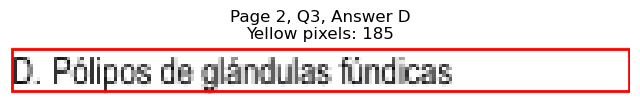


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=215.7, y1=341.8
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 781
Page 2, Q4, A: Yellow percentage: 0.0%


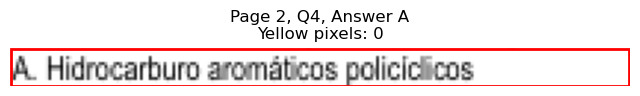

Page 2, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=140.5, y1=354.6
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 409
Page 2, Q4, B: Yellow percentage: 0.0%


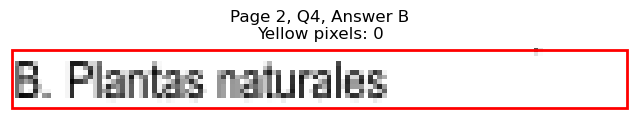

Page 2, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=419.8, y1=341.8
Page 2, Q4, C: Yellow pixels: 1609
Page 2, Q4, C: Total non-white pixels: 2015
Page 2, Q4, C: Yellow percentage: 79.9%


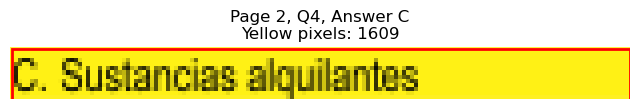

Page 2, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=421.9, y1=354.6
Page 2, Q4, D: Yellow pixels: 155
Page 2, Q4, D: Total non-white pixels: 646
Page 2, Q4, D: Yellow percentage: 24.0%


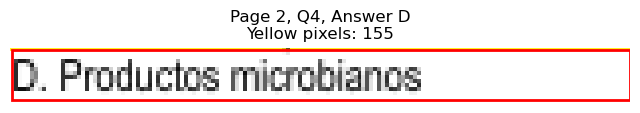


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=160.6, y1=392.4
Page 2, Q5, A: Yellow pixels: 155
Page 2, Q5, A: Total non-white pixels: 635
Page 2, Q5, A: Yellow percentage: 24.4%


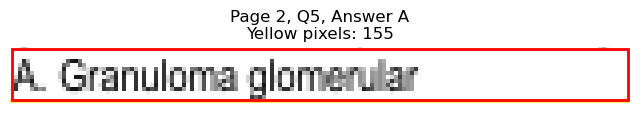

Page 2, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=207.6, y1=405.0
Page 2, Q5, B: Yellow pixels: 2011
Page 2, Q5, B: Total non-white pixels: 2626
Page 2, Q5, B: Yellow percentage: 76.6%


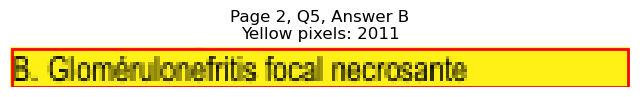

Page 2, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=411.8, y1=392.4
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 477
Page 2, Q5, C: Yellow percentage: 0.0%


Page 2, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=417.3, y1=405.0
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 511
Page 2, Q5, D: Yellow percentage: 0.0%


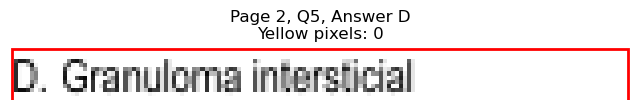


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=493.4, x1=280.0, y1=506.0
Page 2, Q6, A: Yellow pixels: 225
Page 2, Q6, A: Total non-white pixels: 1627
Page 2, Q6, A: Yellow percentage: 13.8%


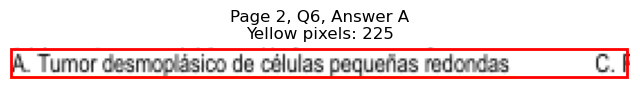

Page 2, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=217.7, y1=518.6
Page 2, Q6, B: Yellow pixels: 2127
Page 2, Q6, B: Total non-white pixels: 2968
Page 2, Q6, B: Yellow percentage: 71.7%


Page 2, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=455.9, y1=506.0
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 688
Page 2, Q6, C: Yellow percentage: 0.0%


Page 2, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=422.8, y1=518.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 549
Page 2, Q6, D: Yellow percentage: 0.0%


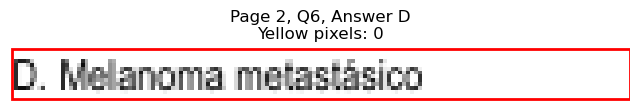


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=107.4, y1=581.7
Page 2, Q7, A: Yellow pixels: 1141
Page 2, Q7, A: Total non-white pixels: 1326
Page 2, Q7, A: Yellow percentage: 86.0%


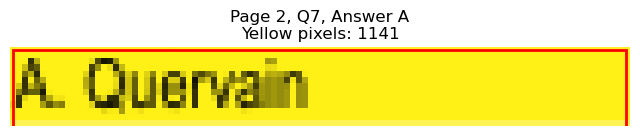

Page 2, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=96.4, y1=594.3
Page 2, Q7, B: Yellow pixels: 91
Page 2, Q7, B: Total non-white pixels: 289
Page 2, Q7, B: Yellow percentage: 31.5%


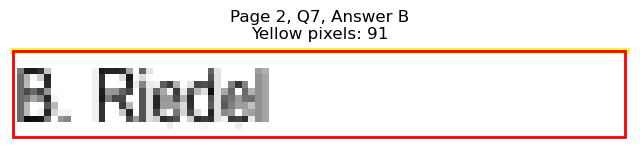

Page 2, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=373.1, y1=581.7
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 254
Page 2, Q7, C: Yellow percentage: 0.0%


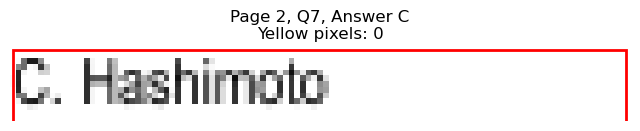

Page 2, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=412.9, y1=594.3
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 460
Page 2, Q7, D: Yellow percentage: 0.0%


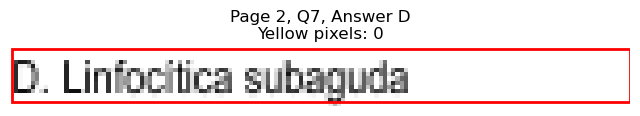


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=142.6, y1=644.9
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 547
Page 2, Q8, A: Yellow percentage: 0.0%


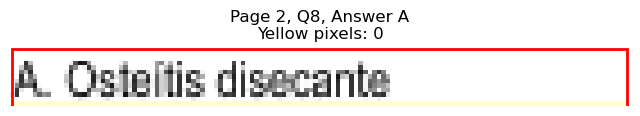

Page 2, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=122.4, y1=657.5
Page 2, Q8, B: Yellow pixels: 1285
Page 2, Q8, B: Total non-white pixels: 1638
Page 2, Q8, B: Yellow percentage: 78.4%


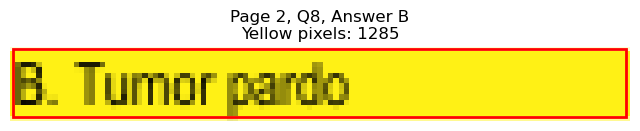

Page 2, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=383.2, y1=644.9
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 315
Page 2, Q8, C: Yellow percentage: 0.0%


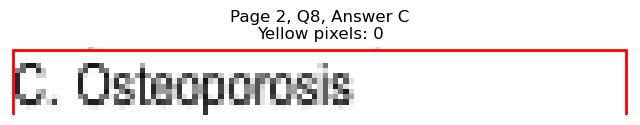

Page 2, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=423.9, y1=657.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 522
Page 2, Q8, D: Yellow percentage: 0.0%


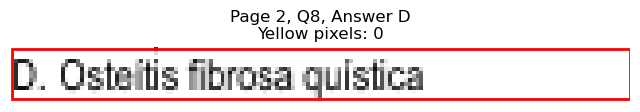


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=708.0, x1=165.6, y1=720.6
Page 2, Q9, A: Yellow pixels: 1643
Page 2, Q9, A: Total non-white pixels: 2240
Page 2, Q9, A: Yellow percentage: 73.3%


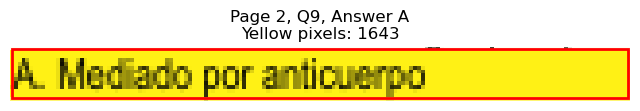

Page 2, Q9 - B: Detected box: x0=56.6, y0=720.6, x1=117.5, y1=733.2
Page 2, Q9, B: Yellow pixels: 112
Page 2, Q9, B: Total non-white pixels: 433
Page 2, Q9, B: Yellow percentage: 25.9%


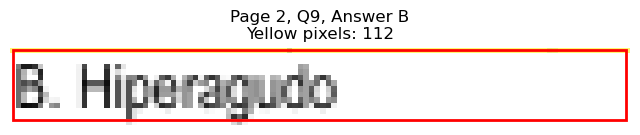

Page 2, Q9 - C: Detected box: x0=315.4, y0=708.0, x1=361.1, y1=720.6
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 200
Page 2, Q9, C: Yellow percentage: 0.0%


Page 2, Q9 - D: Detected box: x0=315.4, y0=720.6, x1=402.8, y1=733.2
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 439
Page 2, Q9, D: Yellow percentage: 0.0%


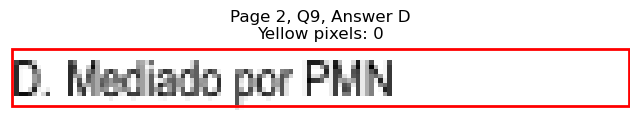


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)

Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=119.4, y1=102.1
Page 3, Q1, A: Yellow pixels: 114
Page 3, Q1, A: Total non-white pixels: 383
Page 3, Q1, A: Yellow percentage: 29.8%


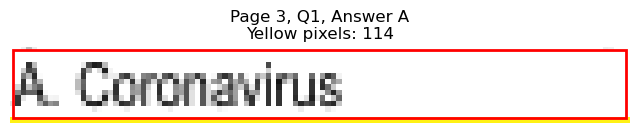

Page 3, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=128.4, y1=114.7
Page 3, Q1, B: Yellow pixels: 1318
Page 3, Q1, B: Total non-white pixels: 1599
Page 3, Q1, B: Yellow percentage: 82.4%


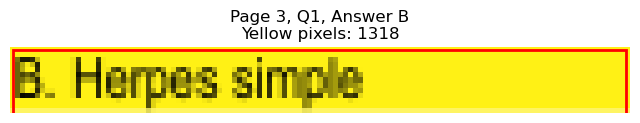

Page 3, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=356.1, y1=102.1
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 168
Page 3, Q1, C: Yellow percentage: 0.0%


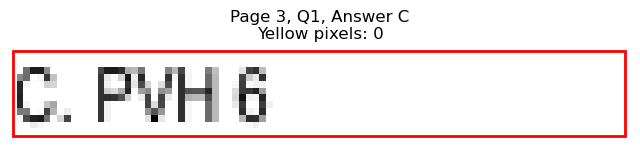

Page 3, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=361.1, y1=114.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 161
Page 3, Q1, D: Yellow percentage: 0.0%


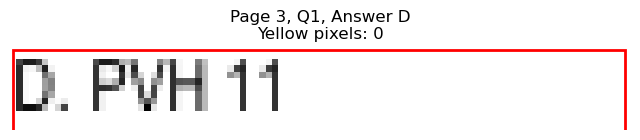


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=83.3, y1=152.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 109
Page 3, Q2, A: Yellow percentage: 0.0%


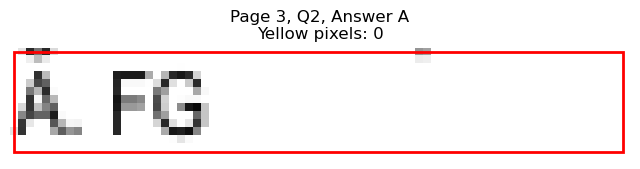

Page 3, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=89.4, y1=165.2
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 136
Page 3, Q2, B: Yellow percentage: 0.0%


Page 3, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=355.1, y1=152.6
Page 3, Q2, C: Yellow pixels: 91
Page 3, Q2, C: Total non-white pixels: 268
Page 3, Q2, C: Yellow percentage: 34.0%


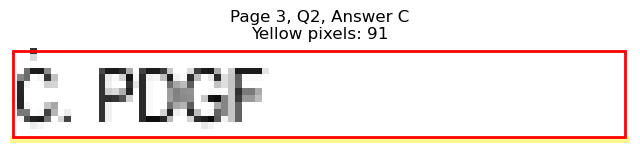

Page 3, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=356.6, y1=165.2
Page 3, Q2, D: Yellow pixels: 1062
Page 3, Q2, D: Total non-white pixels: 1288
Page 3, Q2, D: Yellow percentage: 82.5%



Page 3, Q2 - Selected Answer: D (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=138.0, y1=228.3
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 409
Page 3, Q3, A: Yellow percentage: 0.0%


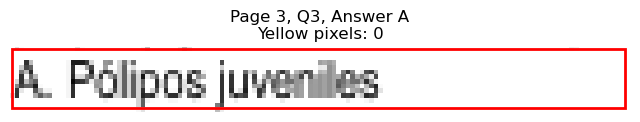

Page 3, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=155.5, y1=240.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 490
Page 3, Q3, B: Yellow percentage: 0.0%


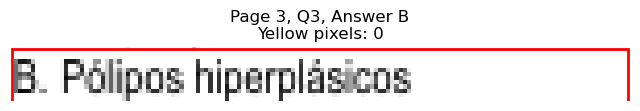

Page 3, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=441.9, y1=228.3
Page 3, Q3, C: Yellow pixels: 1680
Page 3, Q3, C: Total non-white pixels: 2478
Page 3, Q3, C: Yellow percentage: 67.8%


Page 3, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=417.3, y1=240.9
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 641
Page 3, Q3, D: Yellow percentage: 0.0%



Page 3, Q3 - Selected Answer: C (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=219.3, y1=278.7
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 760
Page 3, Q4, A: Yellow percentage: 0.0%


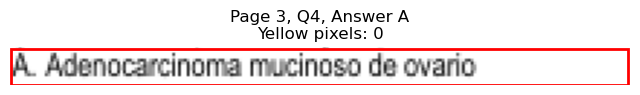

Page 3, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=172.6, y1=291.4
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 563
Page 3, Q4, B: Yellow percentage: 0.0%


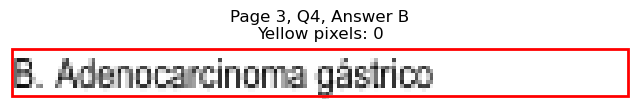

Page 3, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=448.9, y1=278.7
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 638
Page 3, Q4, C: Yellow percentage: 0.0%


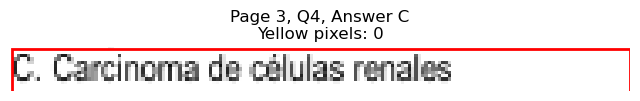

Page 3, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=372.2, y1=291.4
Page 3, Q4, D: Yellow pixels: 1183
Page 3, Q4, D: Total non-white pixels: 1512
Page 3, Q4, D: Yellow percentage: 78.2%


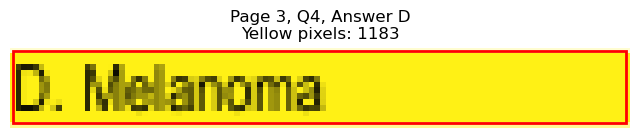


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=175.1, y1=354.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 583
Page 3, Q5, A: Yellow percentage: 0.0%


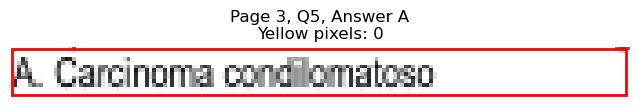

Page 3, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=144.0, y1=367.2
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 389
Page 3, Q5, B: Yellow percentage: 0.0%


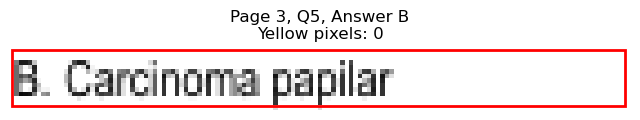

Page 3, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=415.7, y1=354.6
Page 3, Q5, C: Yellow pixels: 1608
Page 3, Q5, C: Total non-white pixels: 2114
Page 3, Q5, C: Yellow percentage: 76.1%


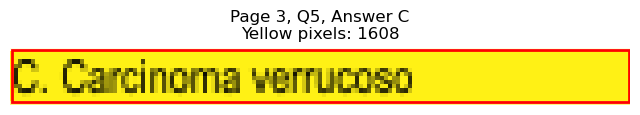

Page 3, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=405.3, y1=367.2
Page 3, Q5, D: Yellow pixels: 141
Page 3, Q5, D: Total non-white pixels: 604
Page 3, Q5, D: Yellow percentage: 23.3%


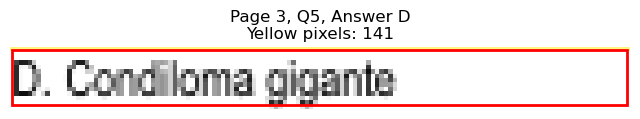


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=210.3, y1=442.9
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 755
Page 3, Q6, A: Yellow percentage: 0.0%


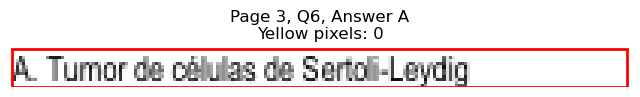

Page 3, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=204.2, y1=455.5
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 723
Page 3, Q6, B: Yellow percentage: 0.0%


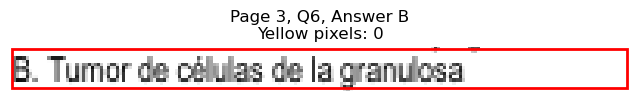

Page 3, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=380.2, y1=442.9
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 418
Page 3, Q6, C: Yellow percentage: 0.0%


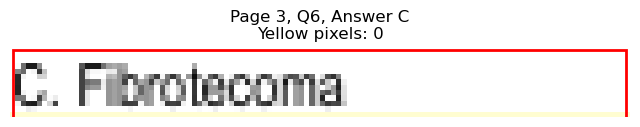

Page 3, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=403.3, y1=455.5
Page 3, Q6, D: Yellow pixels: 1497
Page 3, Q6, D: Total non-white pixels: 1946
Page 3, Q6, D: Yellow percentage: 76.9%


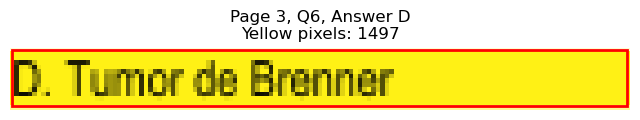


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=113.9, y1=518.6
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 279
Page 3, Q7, A: Yellow percentage: 0.0%


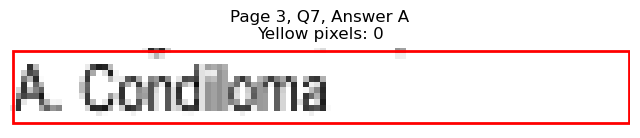

Page 3, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=156.0, y1=531.2
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 490
Page 3, Q7, B: Yellow percentage: 0.0%


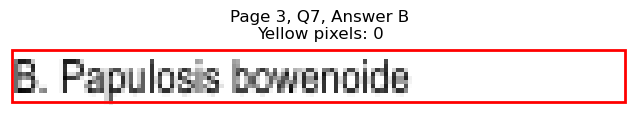

Page 3, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=388.3, y1=518.6
Page 3, Q7, C: Yellow pixels: 124
Page 3, Q7, C: Total non-white pixels: 488
Page 3, Q7, C: Yellow percentage: 25.4%


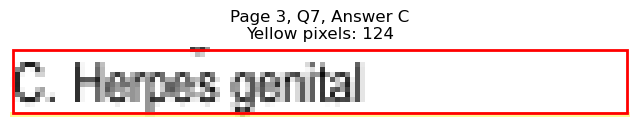

Page 3, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=409.9, y1=531.2
Page 3, Q7, D: Yellow pixels: 1531
Page 3, Q7, D: Total non-white pixels: 2030
Page 3, Q7, D: Yellow percentage: 75.4%



Page 3, Q7 - Selected Answer: D (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=118.5, y1=594.3
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 300
Page 3, Q8, A: Yellow percentage: 0.0%


Page 3, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=95.4, y1=606.9
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 178
Page 3, Q8, B: Yellow percentage: 0.0%


Page 3, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=365.7, y1=594.3
Page 3, Q8, C: Yellow pixels: 1042
Page 3, Q8, C: Total non-white pixels: 1414
Page 3, Q8, C: Yellow percentage: 73.7%


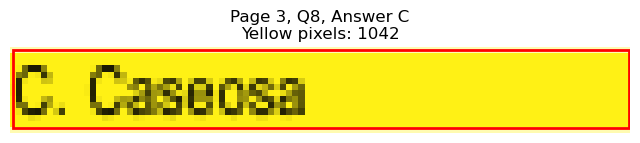

Page 3, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=369.7, y1=606.9
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 374
Page 3, Q8, D: Yellow percentage: 0.0%


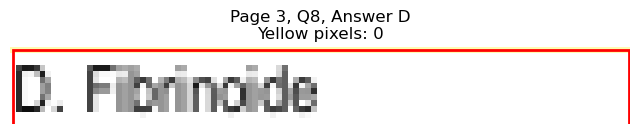


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=118.9, y1=657.5
Page 3, Q9, A: Yellow pixels: 1231
Page 3, Q9, A: Total non-white pixels: 1582
Page 3, Q9, A: Yellow percentage: 77.8%


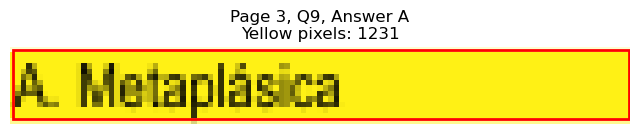

Page 3, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=126.5, y1=670.1
Page 3, Q9, B: Yellow pixels: 121
Page 3, Q9, B: Total non-white pixels: 498
Page 3, Q9, B: Yellow percentage: 24.3%


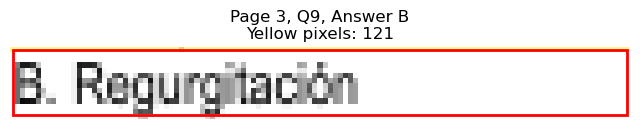

Page 3, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=505.2, y1=657.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 947
Page 3, Q9, C: Yellow percentage: 0.0%


Page 3, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=412.3, y1=670.1
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 509
Page 3, Q9, D: Yellow percentage: 0.0%


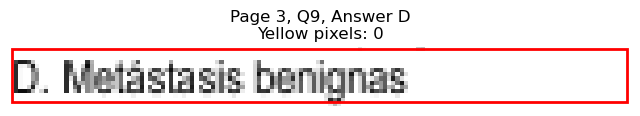


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=75.9, y1=720.6
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 69
Page 3, Q10, A: Yellow percentage: 0.0%


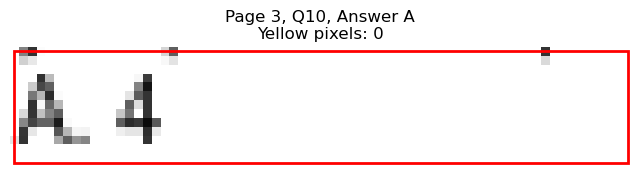

Page 3, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=75.9, y1=733.2
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 69
Page 3, Q10, B: Yellow percentage: 0.0%


Page 3, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=335.1, y1=720.6
Page 3, Q10, C: Yellow pixels: 71
Page 3, Q10, C: Total non-white pixels: 120
Page 3, Q10, C: Yellow percentage: 59.2%


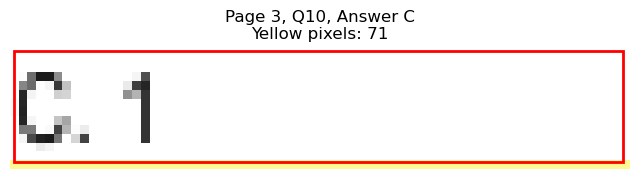

Page 3, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=335.1, y1=733.2
Page 3, Q10, D: Yellow pixels: 874
Page 3, Q10, D: Total non-white pixels: 994
Page 3, Q10, D: Yellow percentage: 87.9%


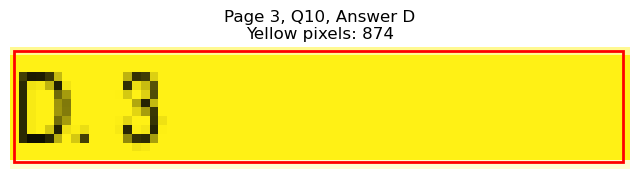


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)

Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=76.8, y1=102.1
Page 4, Q1, A: Yellow pixels: 870
Page 4, Q1, A: Total non-white pixels: 994
Page 4, Q1, A: Yellow percentage: 87.5%


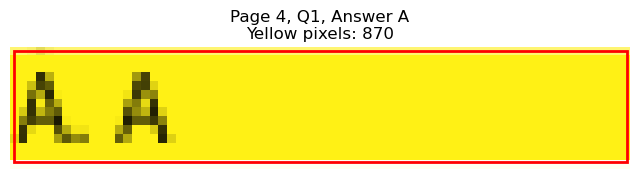

Page 4, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=77.3, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 152
Page 4, Q1, B: Yellow percentage: 0.0%


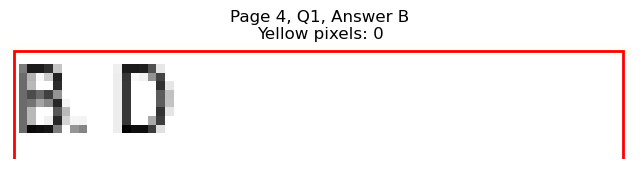

Page 4, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=341.1, y1=102.1
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 99
Page 4, Q1, C: Yellow percentage: 0.0%


Page 4, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=341.1, y1=114.7
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 107
Page 4, Q1, D: Yellow percentage: 0.0%



Page 4, Q1 - Selected Answer: A (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=345.7, y1=152.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 1397
Page 4, Q2, A: Yellow percentage: 0.0%


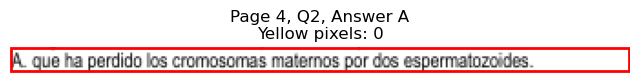

Page 4, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=336.5, y1=165.2
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 1341
Page 4, Q2, B: Yellow percentage: 0.0%


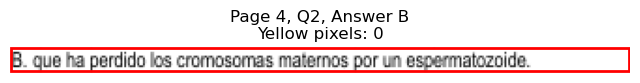

Page 4, Q2 - C: Detected box: x0=56.6, y0=165.1, x1=334.6, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 1643
Page 4, Q2, C: Yellow percentage: 0.0%


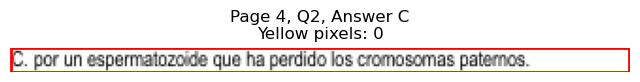

Page 4, Q2 - D: Detected box: x0=56.6, y0=177.7, x1=175.1, y1=190.4
Page 4, Q2, D: Yellow pixels: 1611
Page 4, Q2, D: Total non-white pixels: 2380
Page 4, Q2, D: Yellow percentage: 67.7%


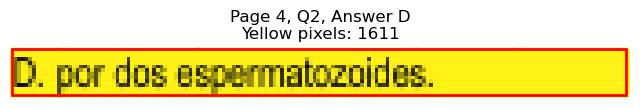


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=173.2, y1=240.9
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 541
Page 4, Q3, A: Yellow percentage: 0.0%


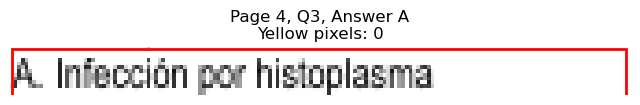

Page 4, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=149.5, y1=253.5
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 488
Page 4, Q3, B: Yellow percentage: 0.0%


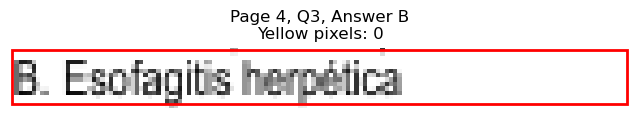

Page 4, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=376.7, y1=240.9
Page 4, Q3, C: Yellow pixels: 1215
Page 4, Q3, C: Total non-white pixels: 1456
Page 4, Q3, C: Yellow percentage: 83.4%


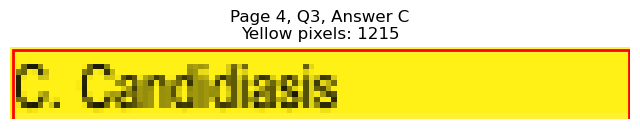

Page 4, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=403.3, y1=253.5
Page 4, Q3, D: Yellow pixels: 139
Page 4, Q3, D: Total non-white pixels: 582
Page 4, Q3, D: Yellow percentage: 23.9%


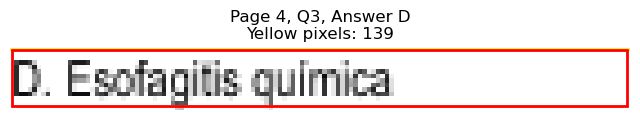


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=174.1, y1=291.4
Page 4, Q4, A: Yellow pixels: 169
Page 4, Q4, A: Total non-white pixels: 723
Page 4, Q4, A: Yellow percentage: 23.4%


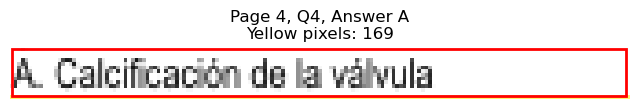

Page 4, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=220.2, y1=304.0
Page 4, Q4, B: Yellow pixels: 2160
Page 4, Q4, B: Total non-white pixels: 3010
Page 4, Q4, B: Yellow percentage: 71.8%


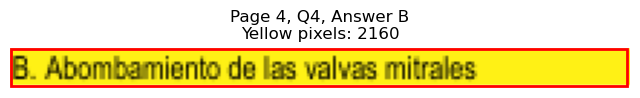

Page 4, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=431.8, y1=291.4
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 577
Page 4, Q4, C: Yellow percentage: 0.0%


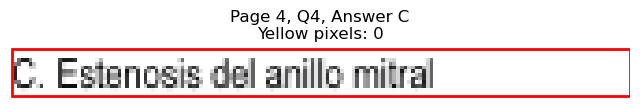

Page 4, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=432.4, y1=304.0
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 579
Page 4, Q4, D: Yellow percentage: 0.0%


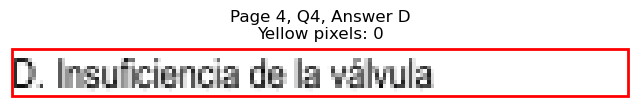


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=174.6, y1=379.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 601
Page 4, Q5, A: Yellow percentage: 0.0%


Page 4, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=192.1, y1=392.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 702
Page 4, Q5, B: Yellow percentage: 0.0%


Page 4, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=426.3, y1=379.8
Page 4, Q5, C: Yellow pixels: 1695
Page 4, Q5, C: Total non-white pixels: 2106
Page 4, Q5, C: Yellow percentage: 80.5%


Page 4, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=424.9, y1=392.4
Page 4, Q5, D: Yellow pixels: 160
Page 4, Q5, D: Total non-white pixels: 744
Page 4, Q5, D: Yellow percentage: 21.5%


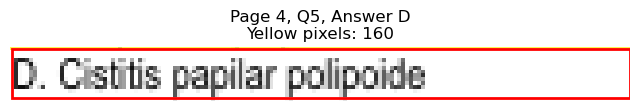


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=174.6, y1=430.3
Page 4, Q6, A: Yellow pixels: 169
Page 4, Q6, A: Total non-white pixels: 720
Page 4, Q6, A: Yellow percentage: 23.5%


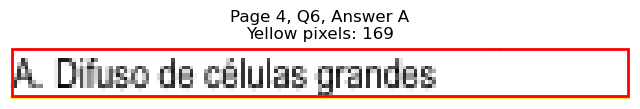

Page 4, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=169.1, y1=442.9
Page 4, Q6, B: Yellow pixels: 1679
Page 4, Q6, B: Total non-white pixels: 2132
Page 4, Q6, B: Yellow percentage: 78.8%


Page 4, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=407.8, y1=430.3
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 442
Page 4, Q6, C: Yellow percentage: 0.0%


Page 4, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=374.2, y1=442.9
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 275
Page 4, Q6, D: Yellow percentage: 0.0%


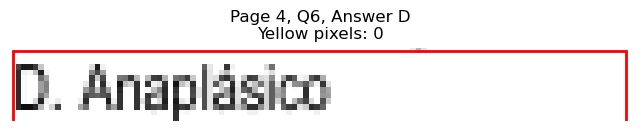


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=154.1, y1=480.7
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 477
Page 4, Q7, A: Yellow percentage: 0.0%


Page 4, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=174.1, y1=493.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 576
Page 4, Q7, B: Yellow percentage: 0.0%


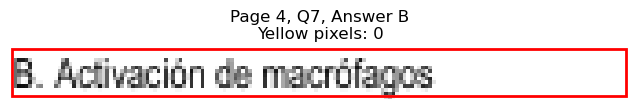

Page 4, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=397.7, y1=480.7
Page 4, Q7, C: Yellow pixels: 1423
Page 4, Q7, C: Total non-white pixels: 1729
Page 4, Q7, C: Yellow percentage: 82.3%


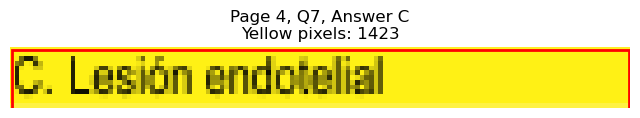

Page 4, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=452.5, y1=493.4
Page 4, Q7, D: Yellow pixels: 188
Page 4, Q7, D: Total non-white pixels: 862
Page 4, Q7, D: Yellow percentage: 21.8%


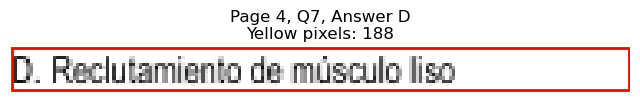


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=156.0, y1=556.4
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 437
Page 4, Q8, A: Yellow percentage: 0.0%


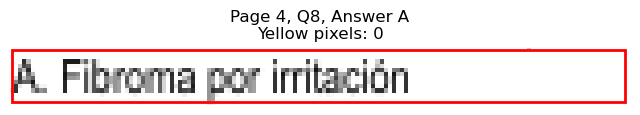

Page 4, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=150.0, y1=569.1
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 425
Page 4, Q8, B: Yellow percentage: 0.0%


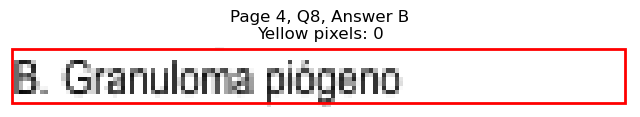

Page 4, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=443.3, y1=556.4
Page 4, Q8, C: Yellow pixels: 1823
Page 4, Q8, C: Total non-white pixels: 2506
Page 4, Q8, C: Yellow percentage: 72.7%


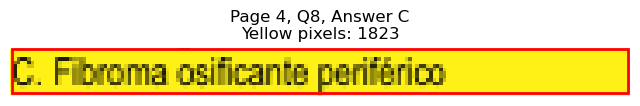

Page 4, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=494.1, y1=569.1
Page 4, Q8, D: Yellow pixels: 225
Page 4, Q8, D: Total non-white pixels: 1106
Page 4, Q8, D: Yellow percentage: 20.3%



Page 4, Q8 - Selected Answer: C (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=181.1, y1=619.5
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 602
Page 4, Q9, A: Yellow percentage: 0.0%


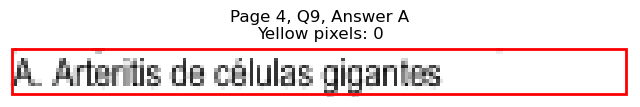

Page 4, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=148.6, y1=632.3
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 439
Page 4, Q9, B: Yellow percentage: 0.0%


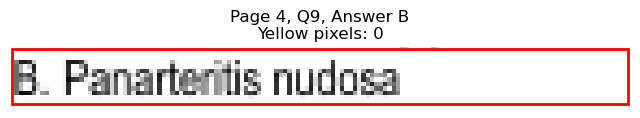

Page 4, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=432.9, y1=619.5
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 562
Page 4, Q9, C: Yellow percentage: 0.0%


Page 4, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=414.8, y1=632.3
Page 4, Q9, D: Yellow pixels: 1433
Page 4, Q9, D: Total non-white pixels: 2100
Page 4, Q9, D: Yellow percentage: 68.2%


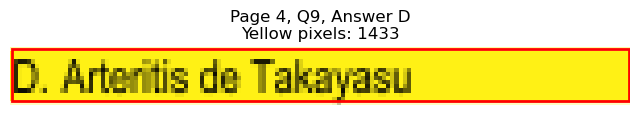


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=165.6, y1=708.0
Page 4, Q10, A: Yellow pixels: 160
Page 4, Q10, A: Total non-white pixels: 864
Page 4, Q10, A: Yellow percentage: 18.5%


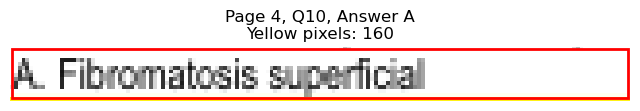

Page 4, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=133.9, y1=720.6
Page 4, Q10, B: Yellow pixels: 1396
Page 4, Q10, B: Total non-white pixels: 1792
Page 4, Q10, B: Yellow percentage: 77.9%


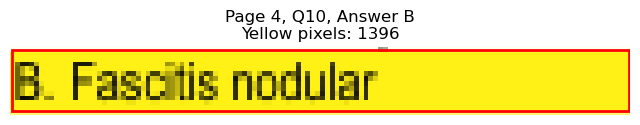

Page 4, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=397.7, y1=708.0
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 376
Page 4, Q10, C: Yellow percentage: 0.0%


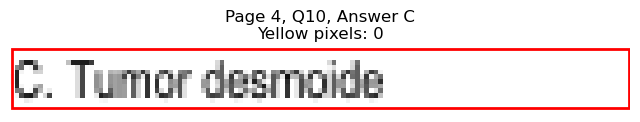

Page 4, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=427.5, y1=720.6
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 540
Page 4, Q10, D: Yellow percentage: 0.0%



Page 4, Q10 - Selected Answer: B (based on yellow pixel count)

Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=152.1, y1=139.9
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 457
Page 5, Q1, A: Yellow percentage: 0.0%


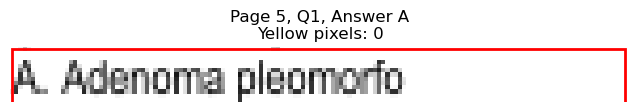

Page 5, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=118.9, y1=152.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 292
Page 5, Q1, B: Yellow percentage: 0.0%


Page 5, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=445.4, y1=139.9
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 626
Page 5, Q1, C: Yellow percentage: 0.0%


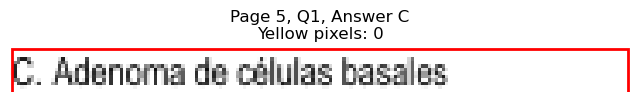

Page 5, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=402.3, y1=152.6
Page 5, Q1, D: Yellow pixels: 1492
Page 5, Q1, D: Total non-white pixels: 1932
Page 5, Q1, D: Yellow percentage: 77.2%


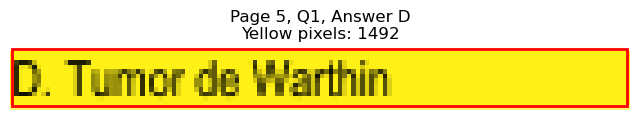


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=164.1, y1=215.6
Page 5, Q2, A: Yellow pixels: 1676
Page 5, Q2, A: Total non-white pixels: 2226
Page 5, Q2, A: Yellow percentage: 75.3%


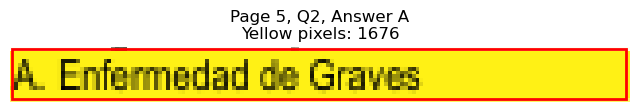

Page 5, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=174.6, y1=228.3
Page 5, Q2, B: Yellow pixels: 169
Page 5, Q2, B: Total non-white pixels: 778
Page 5, Q2, B: Yellow percentage: 21.7%


Page 5, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=428.8, y1=215.6
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 580
Page 5, Q2, C: Yellow percentage: 0.0%


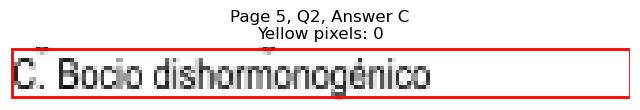

Page 5, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=418.4, y1=228.3
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 512
Page 5, Q2, D: Yellow percentage: 0.0%


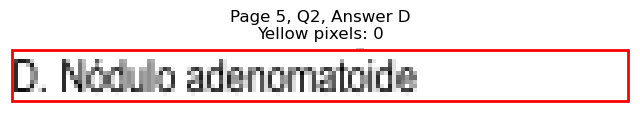


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=173.7, y1=291.4
Page 5, Q3, A: Yellow pixels: 1737
Page 5, Q3, A: Total non-white pixels: 2352
Page 5, Q3, A: Yellow percentage: 73.9%


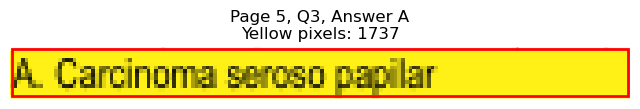

Page 5, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=212.8, y1=304.0
Page 5, Q3, B: Yellow pixels: 207
Page 5, Q3, B: Total non-white pixels: 1004
Page 5, Q3, B: Yellow percentage: 20.6%


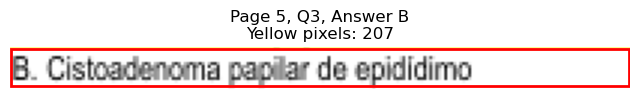

Page 5, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=448.4, y1=291.4
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 632
Page 5, Q3, C: Yellow percentage: 0.0%


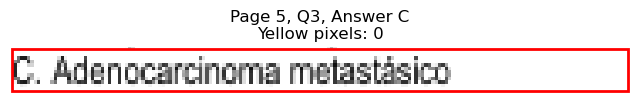

Page 5, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=415.3, y1=304.0
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 517
Page 5, Q3, D: Yellow percentage: 0.0%


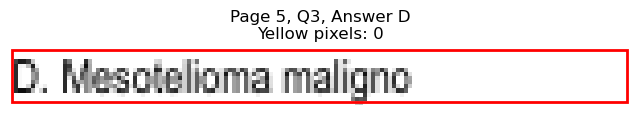


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=179.2, y1=341.8
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 591
Page 5, Q4, A: Yellow percentage: 0.0%


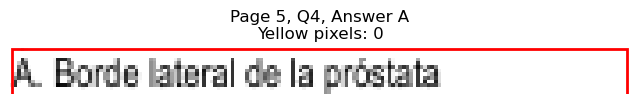

Page 5, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=121.0, y1=354.6
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 318
Page 5, Q4, B: Yellow percentage: 0.0%


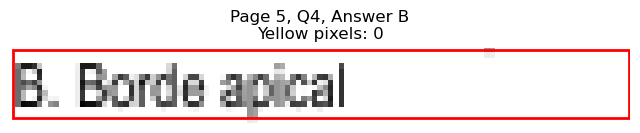

Page 5, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=413.8, y1=341.8
Page 5, Q4, C: Yellow pixels: 1575
Page 5, Q4, C: Total non-white pixels: 1937
Page 5, Q4, C: Yellow percentage: 81.3%


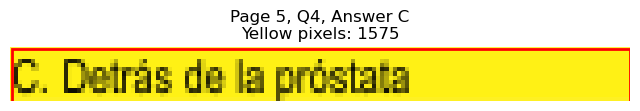

Page 5, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=502.5, y1=354.6
Page 5, Q4, D: Yellow pixels: 224
Page 5, Q4, D: Total non-white pixels: 1097
Page 5, Q4, D: Yellow percentage: 20.4%



Page 5, Q4 - Selected Answer: C (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=124.0, y1=392.4
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 289
Page 5, Q5, A: Yellow percentage: 0.0%


Page 5, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=133.0, y1=405.0
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 347
Page 5, Q5, B: Yellow percentage: 0.0%


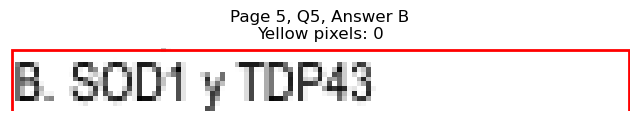

Page 5, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=378.8, y1=392.4
Page 5, Q5, C: Yellow pixels: 114
Page 5, Q5, C: Total non-white pixels: 387
Page 5, Q5, C: Yellow percentage: 29.5%


Page 5, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=363.2, y1=405.0
Page 5, Q5, D: Yellow pixels: 1140
Page 5, Q5, D: Total non-white pixels: 1287
Page 5, Q5, D: Yellow percentage: 88.6%


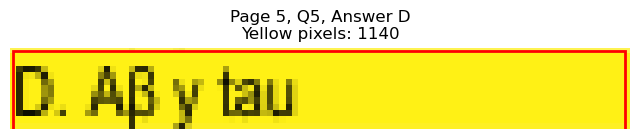


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=93.9, y1=455.5
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 162
Page 5, Q6, A: Yellow percentage: 0.0%


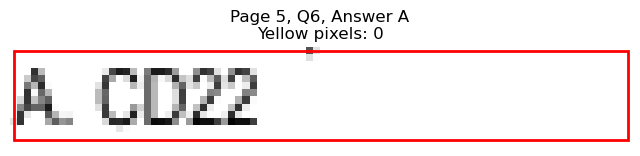

Page 5, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=93.9, y1=468.1
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 170
Page 5, Q6, B: Yellow percentage: 0.0%


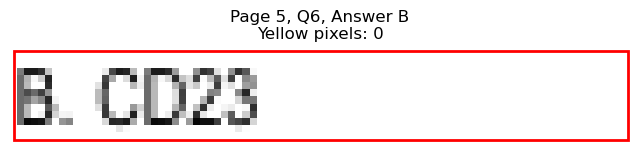

Page 5, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=353.1, y1=455.5
Page 5, Q6, C: Yellow pixels: 89
Page 5, Q6, C: Total non-white pixels: 244
Page 5, Q6, C: Yellow percentage: 36.5%


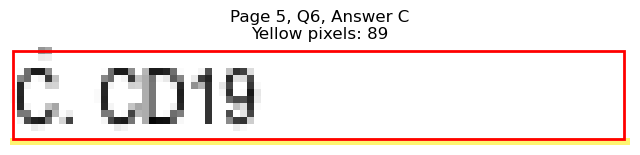

Page 5, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=353.1, y1=468.1
Page 5, Q6, D: Yellow pixels: 1035
Page 5, Q6, D: Total non-white pixels: 1246
Page 5, Q6, D: Yellow percentage: 83.1%


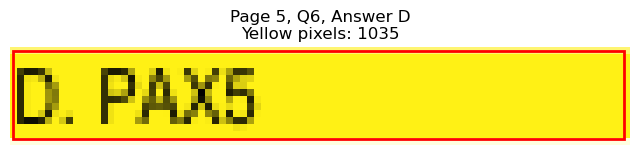


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=134.5, y1=518.6
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 392
Page 5, Q7, A: Yellow percentage: 0.0%


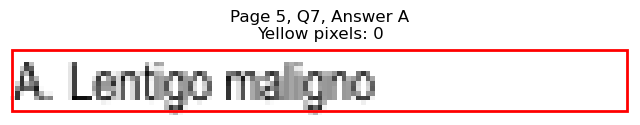

Page 5, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=171.1, y1=531.2
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 568
Page 5, Q7, B: Yellow percentage: 0.0%


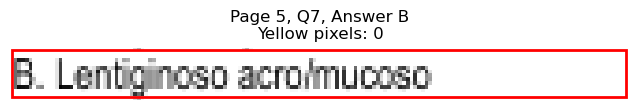

Page 5, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=412.9, y1=518.6
Page 5, Q7, C: Yellow pixels: 1553
Page 5, Q7, C: Total non-white pixels: 2072
Page 5, Q7, C: Yellow percentage: 75.0%


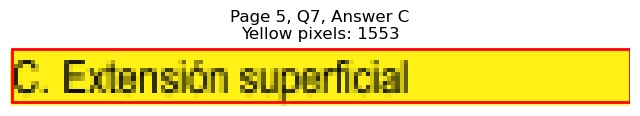

Page 5, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=397.7, y1=531.2
Page 5, Q7, D: Yellow pixels: 133
Page 5, Q7, D: Total non-white pixels: 532
Page 5, Q7, D: Yellow percentage: 25.0%


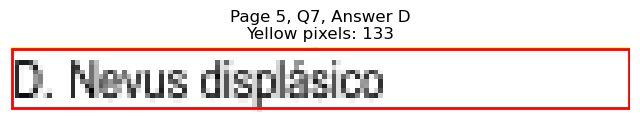


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=118.5, y1=569.1
Page 5, Q8, A: Yellow pixels: 1224
Page 5, Q8, A: Total non-white pixels: 1582
Page 5, Q8, A: Yellow percentage: 77.4%


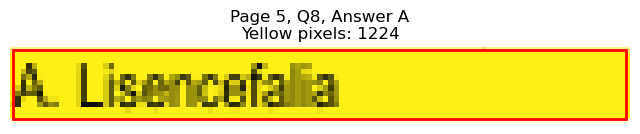

Page 5, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=124.9, y1=581.7
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 448
Page 5, Q8, B: Yellow percentage: 0.0%


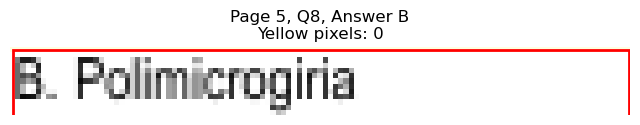

Page 5, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=402.3, y1=569.1
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 440
Page 5, Q8, C: Yellow percentage: 0.0%


Page 5, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=378.2, y1=581.7
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 315
Page 5, Q8, D: Yellow percentage: 0.0%


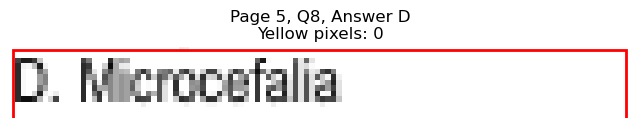


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=156.6, y1=644.9
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 476
Page 5, Q9, A: Yellow percentage: 0.0%


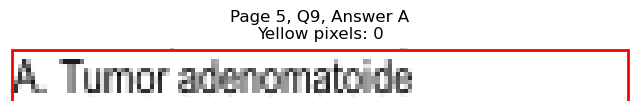

Page 5, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=122.4, y1=657.5
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 316
Page 5, Q9, B: Yellow percentage: 0.0%


Page 5, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=541.2, y1=644.9
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 1318
Page 5, Q9, C: Yellow percentage: 0.0%


Page 5, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=389.7, y1=657.5
Page 5, Q9, D: Yellow pixels: 1378
Page 5, Q9, D: Total non-white pixels: 1750
Page 5, Q9, D: Yellow percentage: 78.7%



Page 5, Q9 - Selected Answer: D (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=134.1, y1=733.2
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 364
Page 5, Q10, A: Yellow percentage: 0.0%


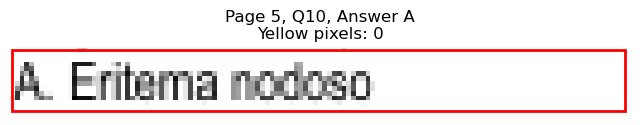

Page 5, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=199.7, y1=745.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 710
Page 5, Q10, B: Yellow percentage: 0.0%


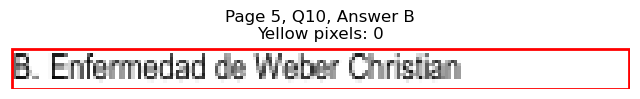

Page 5, Q10 - C: Detected box: x0=315.4, y0=720.6, x1=401.2, y1=733.2
Page 5, Q10, C: Yellow pixels: 137
Page 5, Q10, C: Total non-white pixels: 551
Page 5, Q10, C: Yellow percentage: 24.9%


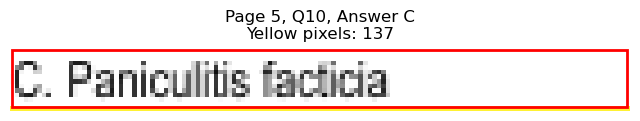

Page 5, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=398.7, y1=745.8
Page 5, Q10, D: Yellow pixels: 1426
Page 5, Q10, D: Total non-white pixels: 1742
Page 5, Q10, D: Yellow percentage: 81.9%


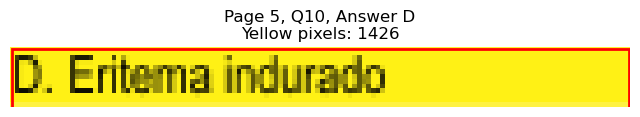


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)

Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=168.6, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 700
Page 6, Q1, A: Yellow percentage: 0.0%


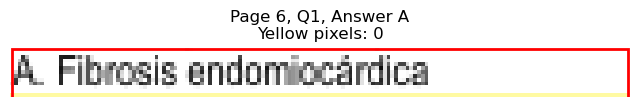

Page 6, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=175.1, y1=127.3
Page 6, Q1, B: Yellow pixels: 1588
Page 6, Q1, B: Total non-white pixels: 2380
Page 6, Q1, B: Yellow percentage: 66.7%


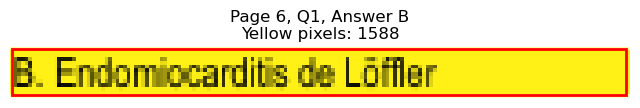

Page 6, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=437.3, y1=114.7
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 629
Page 6, Q1, C: Yellow percentage: 0.0%


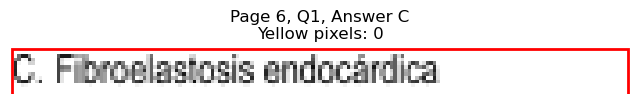

Page 6, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=425.3, y1=127.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 535
Page 6, Q1, D: Yellow percentage: 0.0%


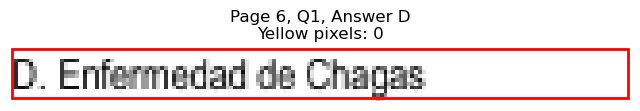


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=263.4, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 1069
Page 6, Q2, A: Yellow percentage: 0.0%


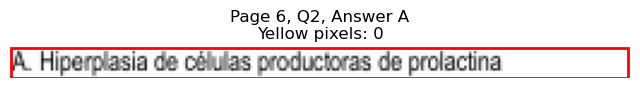

Page 6, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=195.1, y1=190.4
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 684
Page 6, Q2, B: Yellow percentage: 0.0%


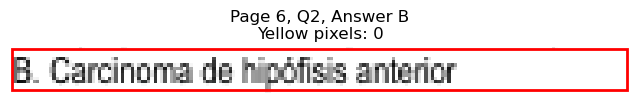

Page 6, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=410.8, y1=177.8
Page 6, Q2, C: Yellow pixels: 1558
Page 6, Q2, C: Total non-white pixels: 1898
Page 6, Q2, C: Yellow percentage: 82.1%


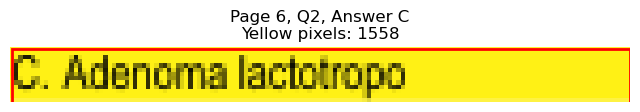

Page 6, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=465.5, y1=190.4
Page 6, Q2, D: Yellow pixels: 201
Page 6, Q2, D: Total non-white pixels: 924
Page 6, Q2, D: Yellow percentage: 21.8%


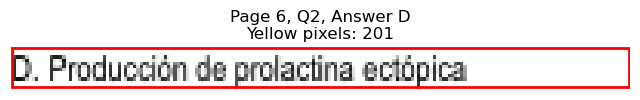


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=165.3, y1=240.9
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 534
Page 6, Q3, A: Yellow percentage: 0.0%


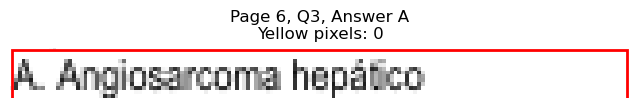

Page 6, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=143.5, y1=253.5
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 415
Page 6, Q3, B: Yellow percentage: 0.0%


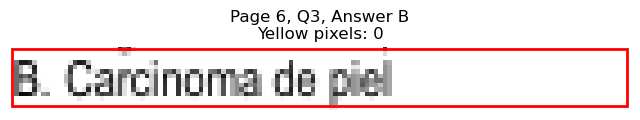

Page 6, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=421.4, y1=240.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 657
Page 6, Q3, C: Yellow percentage: 0.0%


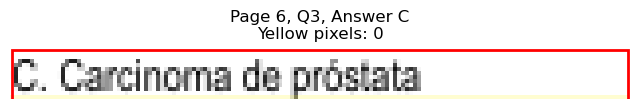

Page 6, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=418.3, y1=253.5
Page 6, Q3, D: Yellow pixels: 1635
Page 6, Q3, D: Total non-white pixels: 2156
Page 6, Q3, D: Yellow percentage: 75.8%


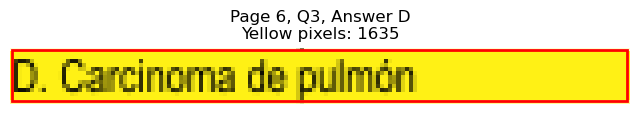


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=89.4, y1=291.4
Page 6, Q4, A: Yellow pixels: 84
Page 6, Q4, A: Total non-white pixels: 224
Page 6, Q4, A: Yellow percentage: 37.5%


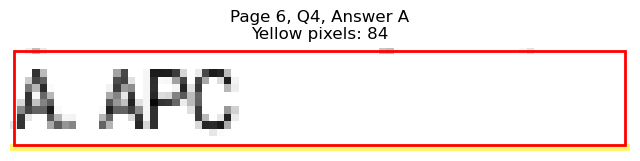

Page 6, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=87.9, y1=304.0
Page 6, Q4, B: Yellow pixels: 960
Page 6, Q4, B: Total non-white pixels: 1148
Page 6, Q4, B: Yellow percentage: 83.6%


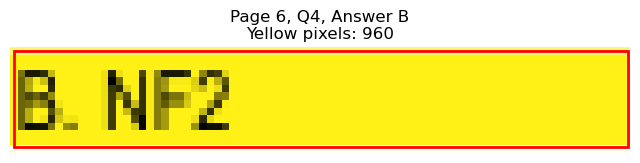

Page 6, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=349.1, y1=291.4
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 120
Page 6, Q4, C: Yellow percentage: 0.0%


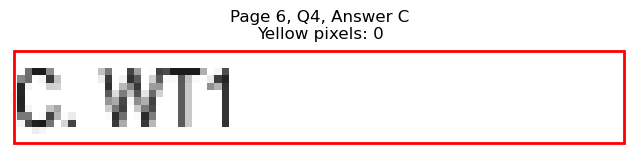

Page 6, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=346.1, y1=304.0
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 132
Page 6, Q4, D: Yellow percentage: 0.0%


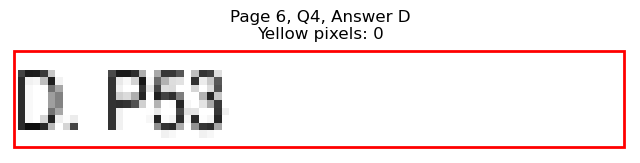


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=136.5, y1=379.8
Page 6, Q5, A: Yellow pixels: 1367
Page 6, Q5, A: Total non-white pixels: 1703
Page 6, Q5, A: Yellow percentage: 80.3%


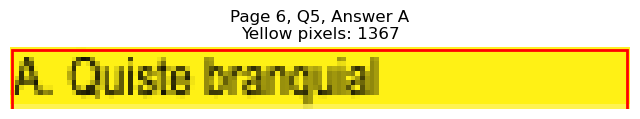

Page 6, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=201.6, y1=392.4
Page 6, Q5, B: Yellow pixels: 196
Page 6, Q5, B: Total non-white pixels: 910
Page 6, Q5, B: Yellow percentage: 21.5%


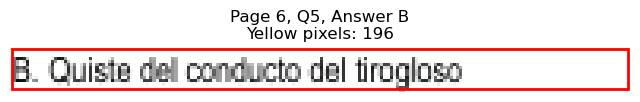

Page 6, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=412.9, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 470
Page 6, Q5, C: Yellow percentage: 0.0%


Page 6, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=466.5, y1=392.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 772
Page 6, Q5, D: Yellow percentage: 0.0%


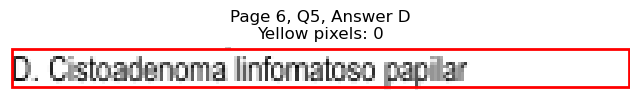


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=229.4, y1=455.5
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 848
Page 6, Q6, A: Yellow percentage: 0.0%


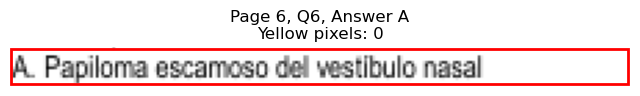

Page 6, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=207.6, y1=468.1
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 735
Page 6, Q6, B: Yellow percentage: 0.0%


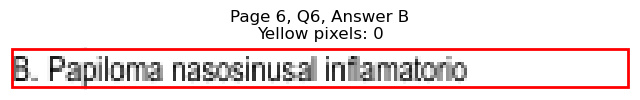

Page 6, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=391.3, y1=455.5
Page 6, Q6, C: Yellow pixels: 127
Page 6, Q6, C: Total non-white pixels: 521
Page 6, Q6, C: Yellow percentage: 24.4%


Page 6, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=476.0, y1=468.1
Page 6, Q6, D: Yellow pixels: 2163
Page 6, Q6, D: Total non-white pixels: 2968
Page 6, Q6, D: Yellow percentage: 72.9%



Page 6, Q6 - Selected Answer: D (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=153.0, y1=506.0
Page 6, Q7, A: Yellow pixels: 1573
Page 6, Q7, A: Total non-white pixels: 1924
Page 6, Q7, A: Yellow percentage: 81.8%


Page 6, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=115.0, y1=518.6
Page 6, Q7, B: Yellow pixels: 109
Page 6, Q7, B: Total non-white pixels: 394
Page 6, Q7, B: Yellow percentage: 27.7%


Page 6, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=367.6, y1=506.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 237
Page 6, Q7, C: Yellow percentage: 0.0%


Page 6, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=457.0, y1=518.6
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 711
Page 6, Q7, D: Yellow percentage: 0.0%


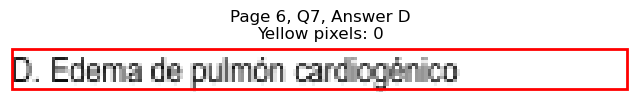


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=231.3, y1=569.1
Page 6, Q8, A: Yellow pixels: 2186
Page 6, Q8, A: Total non-white pixels: 3164
Page 6, Q8, A: Yellow percentage: 69.1%


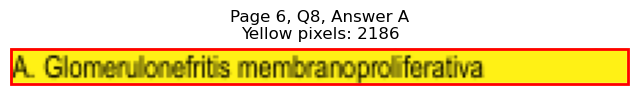

Page 6, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=198.6, y1=581.7
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 934
Page 6, Q8, B: Yellow percentage: 0.0%


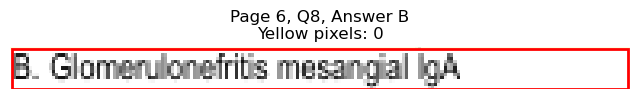

Page 6, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=494.5, y1=569.1
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 866
Page 6, Q8, C: Yellow percentage: 0.0%


Page 6, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=433.4, y1=581.7
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 587
Page 6, Q8, D: Yellow percentage: 0.0%



Page 6, Q8 - Selected Answer: A (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=136.5, y1=657.5
Page 6, Q9, A: Yellow pixels: 1414
Page 6, Q9, A: Total non-white pixels: 1834
Page 6, Q9, A: Yellow percentage: 77.1%


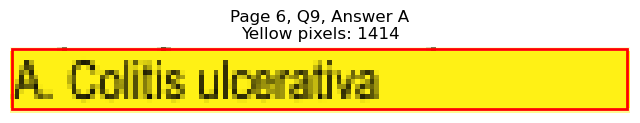

Page 6, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=159.6, y1=670.1
Page 6, Q9, B: Yellow pixels: 154
Page 6, Q9, B: Total non-white pixels: 639
Page 6, Q9, B: Yellow percentage: 24.1%


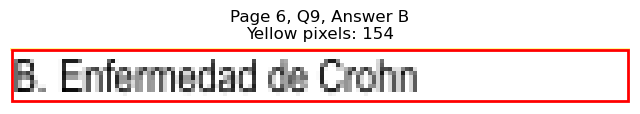

Page 6, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=439.4, y1=657.5
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 633
Page 6, Q9, C: Yellow percentage: 0.0%


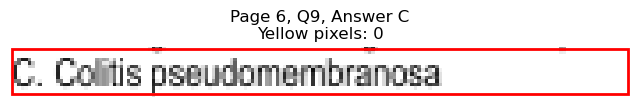

Page 6, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=409.7, y1=670.1
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 461
Page 6, Q9, D: Yellow percentage: 0.0%


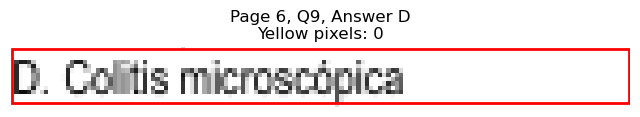


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=235.2, y1=708.0
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 911
Page 6, Q10, A: Yellow percentage: 0.0%


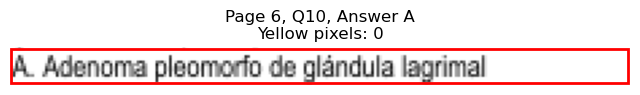

Page 6, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=137.1, y1=720.6
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 397
Page 6, Q10, B: Yellow percentage: 0.0%


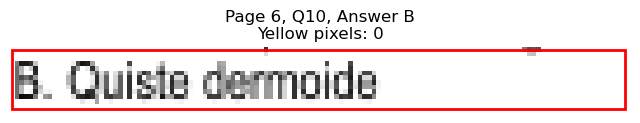

Page 6, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=473.0, y1=708.0
Page 6, Q10, C: Yellow pixels: 2138
Page 6, Q10, C: Total non-white pixels: 2721
Page 6, Q10, C: Yellow percentage: 78.6%


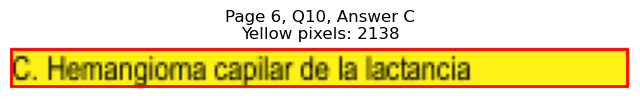

Page 6, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=383.7, y1=720.6
Page 6, Q10, D: Yellow pixels: 113
Page 6, Q10, D: Total non-white pixels: 453
Page 6, Q10, D: Yellow percentage: 24.9%


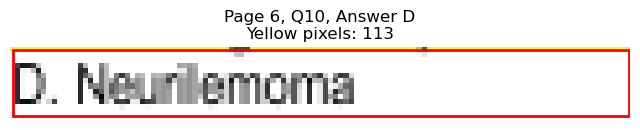


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)
Page 6, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=132.0, y1=758.4
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 374
Page 6, Q11, A: Yellow percentage: 0.0%


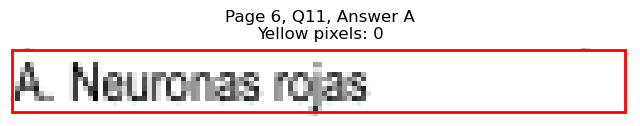

Page 6, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=142.0, y1=771.1
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 419
Page 6, Q11, B: Yellow percentage: 0.0%


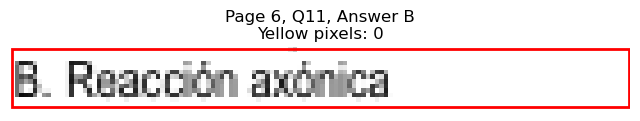

Page 6, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=357.2, y1=758.4
Page 6, Q11, C: Yellow pixels: 1072
Page 6, Q11, C: Total non-white pixels: 1302
Page 6, Q11, C: Yellow percentage: 82.3%


Page 6, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=408.4, y1=771.1
Page 6, Q11, D: Yellow pixels: 144
Page 6, Q11, D: Total non-white pixels: 617
Page 6, Q11, D: Yellow percentage: 23.3%


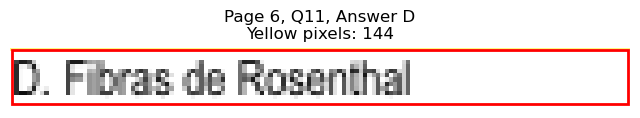


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)

Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=163.1, y1=102.1
Page 7, Q1, A: Yellow pixels: 158
Page 7, Q1, A: Total non-white pixels: 684
Page 7, Q1, A: Yellow percentage: 23.1%


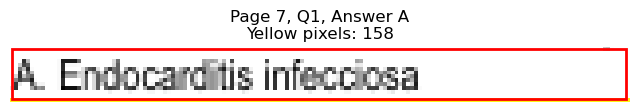

Page 7, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=138.5, y1=114.7
Page 7, Q1, B: Yellow pixels: 1419
Page 7, Q1, B: Total non-white pixels: 1729
Page 7, Q1, B: Yellow percentage: 82.1%


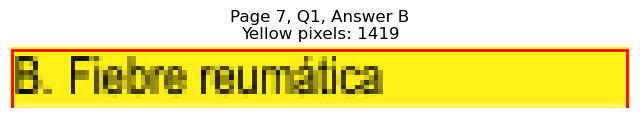

Page 7, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=451.4, y1=102.1
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 641
Page 7, Q1, C: Yellow percentage: 0.0%


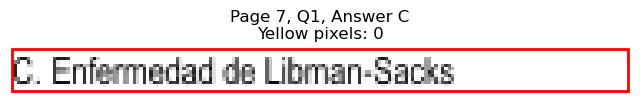

Page 7, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=481.5, y1=114.7
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 827
Page 7, Q1, D: Yellow percentage: 0.0%


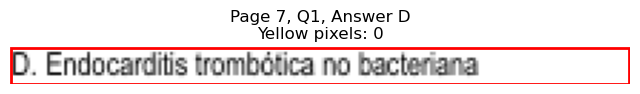


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=110.9, y1=152.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 256
Page 7, Q2, A: Yellow percentage: 0.0%


Page 7, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=131.1, y1=165.2
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 345
Page 7, Q2, B: Yellow percentage: 0.0%


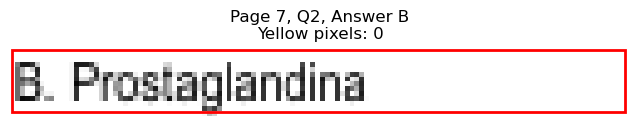

Page 7, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=348.1, y1=152.6
Page 7, Q2, C: Yellow pixels: 985
Page 7, Q2, C: Total non-white pixels: 1176
Page 7, Q2, C: Yellow percentage: 83.8%


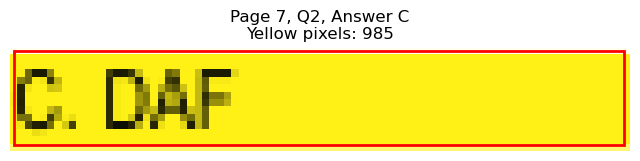

Page 7, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=355.6, y1=165.2
Page 7, Q2, D: Yellow pixels: 91
Page 7, Q2, D: Total non-white pixels: 274
Page 7, Q2, D: Yellow percentage: 33.2%


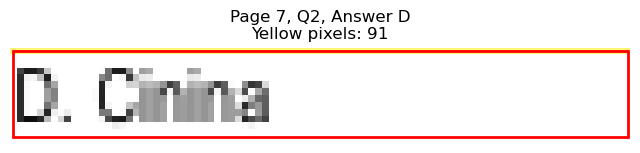


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=190.3, x1=136.5, y1=203.0
Page 7, Q3, A: Yellow pixels: 1414
Page 7, Q3, A: Total non-white pixels: 1703
Page 7, Q3, A: Yellow percentage: 83.0%


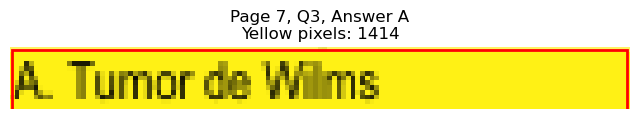

Page 7, Q3 - B: Detected box: x0=56.6, y0=202.9, x1=210.8, y1=215.6
Page 7, Q3, B: Yellow pixels: 205
Page 7, Q3, B: Total non-white pixels: 935
Page 7, Q3, B: Yellow percentage: 21.9%


Page 7, Q3 - C: Detected box: x0=315.4, y0=190.3, x1=418.3, y1=203.0
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 478
Page 7, Q3, C: Yellow percentage: 0.0%


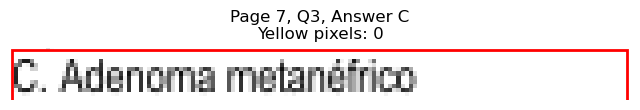

Page 7, Q3 - D: Detected box: x0=315.4, y0=202.9, x1=379.1, y1=215.6
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 323
Page 7, Q3, D: Yellow percentage: 0.0%


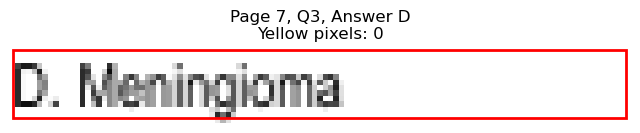


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=240.8, x1=101.9, y1=253.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 204
Page 7, Q4, A: Yellow percentage: 0.0%


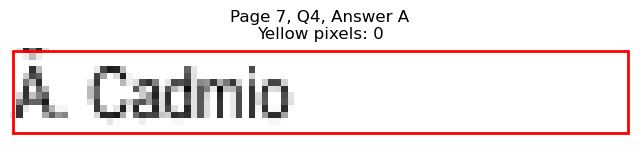

Page 7, Q4 - B: Detected box: x0=56.6, y0=253.4, x1=105.9, y1=266.1
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 236
Page 7, Q4, B: Yellow percentage: 0.0%


Page 7, Q4 - C: Detected box: x0=315.4, y0=240.8, x1=395.2, y1=253.5
Page 7, Q4, C: Yellow pixels: 131
Page 7, Q4, C: Total non-white pixels: 497
Page 7, Q4, C: Yellow percentage: 26.4%


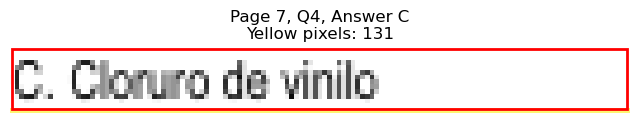

Page 7, Q4 - D: Detected box: x0=315.4, y0=253.4, x1=365.7, y1=266.1
Page 7, Q4, D: Yellow pixels: 1142
Page 7, Q4, D: Total non-white pixels: 1414
Page 7, Q4, D: Yellow percentage: 80.8%


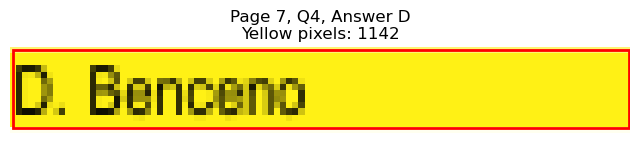


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=129.0, y1=329.2
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 350
Page 7, Q5, A: Yellow percentage: 0.0%


Page 7, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=133.9, y1=341.8
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 365
Page 7, Q5, B: Yellow percentage: 0.0%


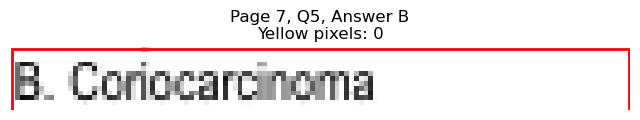

Page 7, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=422.8, y1=329.2
Page 7, Q5, C: Yellow pixels: 1508
Page 7, Q5, C: Total non-white pixels: 2212
Page 7, Q5, C: Yellow percentage: 68.2%


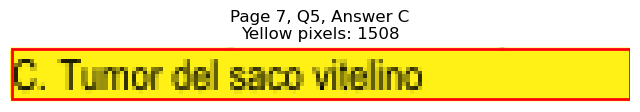

Page 7, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=423.8, y1=341.8
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 670
Page 7, Q5, D: Yellow percentage: 0.0%



Page 7, Q5 - Selected Answer: C (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=367.1, x1=253.5, y1=379.8
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 947
Page 7, Q6, A: Yellow percentage: 0.0%


Page 7, Q6 - B: Detected box: x0=56.6, y0=379.7, x1=345.5, y1=392.4
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 1403
Page 7, Q6, B: Yellow percentage: 0.0%


Page 7, Q6 - C: Detected box: x0=56.6, y0=392.3, x1=332.1, y1=405.0
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 1654
Page 7, Q6, C: Yellow percentage: 0.0%


Page 7, Q6 - D: Detected box: x0=56.6, y0=404.9, x1=224.3, y1=417.6
Page 7, Q6, D: Yellow pixels: 2226
Page 7, Q6, D: Total non-white pixels: 3066
Page 7, Q6, D: Yellow percentage: 72.6%


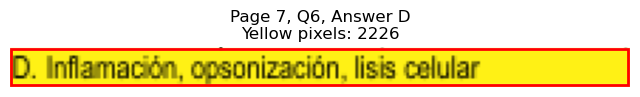


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=159.6, y1=493.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 513
Page 7, Q7, A: Yellow percentage: 0.0%


Page 7, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=180.1, y1=506.0
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 606
Page 7, Q7, B: Yellow percentage: 0.0%


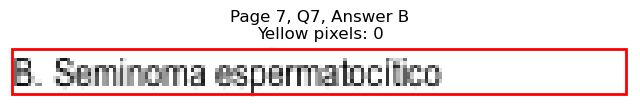

Page 7, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=423.8, y1=493.4
Page 7, Q7, C: Yellow pixels: 1507
Page 7, Q7, C: Total non-white pixels: 2226
Page 7, Q7, C: Yellow percentage: 67.7%


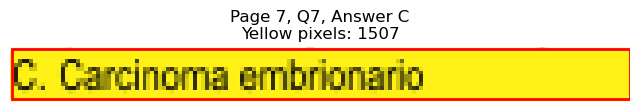

Page 7, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=422.8, y1=506.0
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 659
Page 7, Q7, D: Yellow percentage: 0.0%


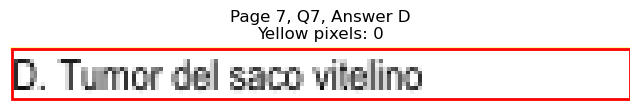


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=159.0, y1=556.4
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 520
Page 7, Q8, A: Yellow percentage: 0.0%


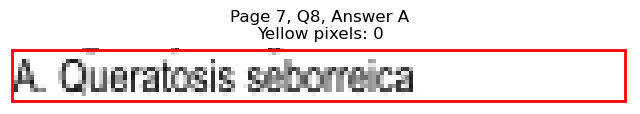

Page 7, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=148.6, y1=569.1
Page 7, Q8, B: Yellow pixels: 1484
Page 7, Q8, B: Total non-white pixels: 2002
Page 7, Q8, B: Yellow percentage: 74.1%


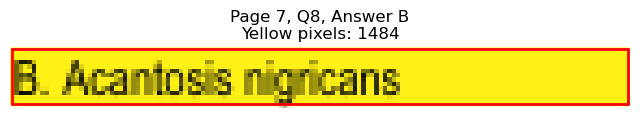

Page 7, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=359.7, y1=556.4
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 202
Page 7, Q8, C: Yellow percentage: 0.0%


Page 7, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=408.8, y1=569.1
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 434
Page 7, Q8, D: Yellow percentage: 0.0%


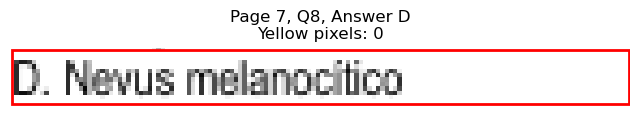


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=75.9, y1=619.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 70
Page 7, Q9, A: Yellow percentage: 0.0%


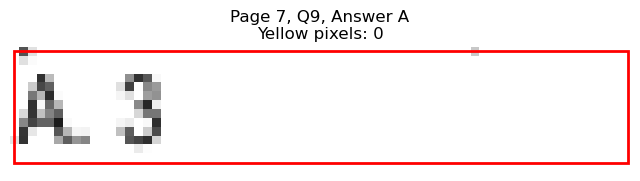

Page 7, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=80.9, y1=632.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 94
Page 7, Q9, B: Yellow percentage: 0.0%


Page 7, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=340.1, y1=619.5
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 94
Page 7, Q9, C: Yellow percentage: 0.0%


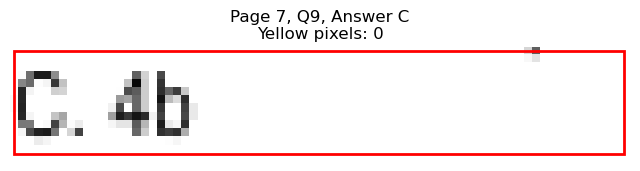

Page 7, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=335.1, y1=632.3
Page 7, Q9, D: Yellow pixels: 803
Page 7, Q9, D: Total non-white pixels: 994
Page 7, Q9, D: Yellow percentage: 80.8%


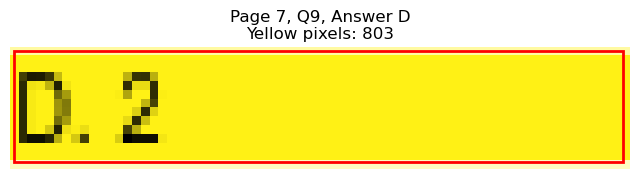


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=657.4, x1=89.9, y1=670.1
Page 7, Q10, A: Yellow pixels: 84
Page 7, Q10, A: Total non-white pixels: 241
Page 7, Q10, A: Yellow percentage: 34.9%


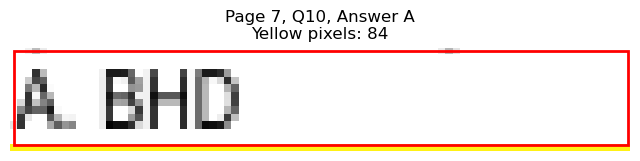

Page 7, Q10 - B: Detected box: x0=56.6, y0=670.0, x1=97.3, y1=682.7
Page 7, Q10, B: Yellow pixels: 1055
Page 7, Q10, B: Total non-white pixels: 1196
Page 7, Q10, B: Yellow percentage: 88.2%


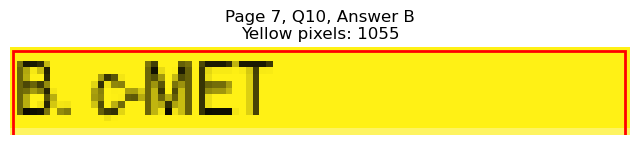

Page 7, Q10 - C: Detected box: x0=315.4, y0=657.4, x1=347.6, y1=670.1
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 120
Page 7, Q10, C: Yellow percentage: 0.0%


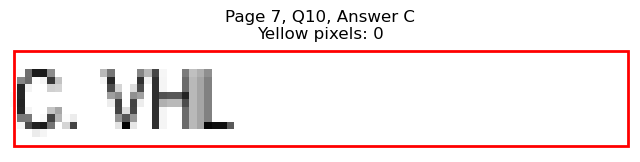

Page 7, Q10 - D: Detected box: x0=315.4, y0=670.0, x1=342.1, y1=682.7
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 103
Page 7, Q10, D: Yellow percentage: 0.0%


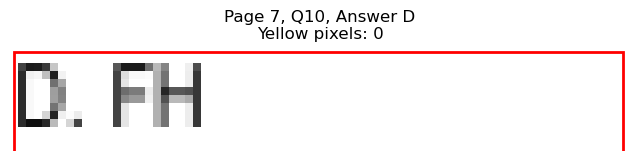


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)
Page 7, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=167.1, y1=758.4
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 524
Page 7, Q11, A: Yellow percentage: 0.0%


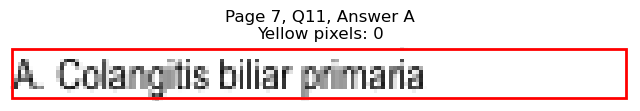

Page 7, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=199.2, y1=771.1
Page 7, Q11, B: Yellow pixels: 1951
Page 7, Q11, B: Total non-white pixels: 2716
Page 7, Q11, B: Yellow percentage: 71.8%


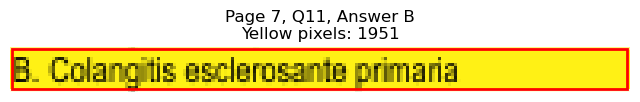

Page 7, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=421.4, y1=758.4
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 508
Page 7, Q11, C: Yellow percentage: 0.0%


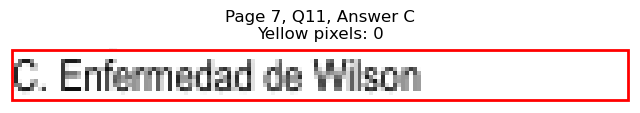

Page 7, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=446.3, y1=771.1
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 657
Page 7, Q11, D: Yellow percentage: 0.0%


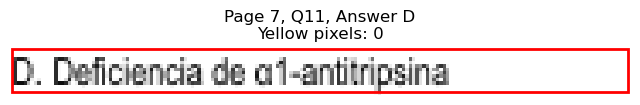


Page 7, Q11 - Selected Answer: B (based on yellow pixel count)

Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=115.9, y1=102.1
Page 8, Q1, A: Yellow pixels: 110
Page 8, Q1, A: Total non-white pixels: 391
Page 8, Q1, A: Yellow percentage: 28.1%


Page 8, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=141.5, y1=114.7
Page 8, Q1, B: Yellow pixels: 1467
Page 8, Q1, B: Total non-white pixels: 1768
Page 8, Q1, B: Yellow percentage: 83.0%


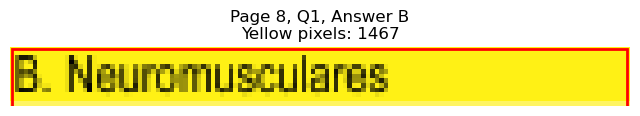

Page 8, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=389.7, y1=102.1
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 368
Page 8, Q1, C: Yellow percentage: 0.0%


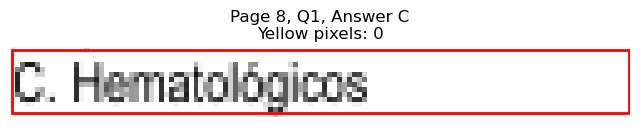

Page 8, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=392.7, y1=114.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 391
Page 8, Q1, D: Yellow percentage: 0.0%



Page 8, Q1 - Selected Answer: B (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=185.9, y1=177.8
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 533
Page 8, Q2, A: Yellow percentage: 0.0%


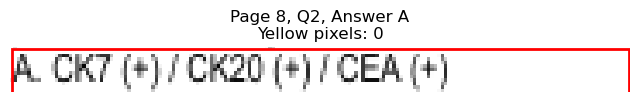

Page 8, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=179.1, y1=190.4
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 522
Page 8, Q2, B: Yellow percentage: 0.0%


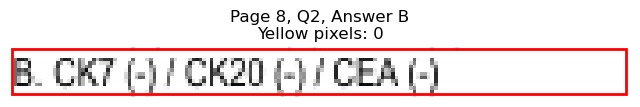

Page 8, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=440.6, y1=177.8
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 680
Page 8, Q2, C: Yellow percentage: 0.0%


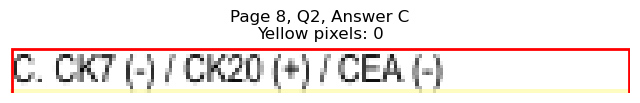

Page 8, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=442.9, y1=190.4
Page 8, Q2, D: Yellow pixels: 1720
Page 8, Q2, D: Total non-white pixels: 2492
Page 8, Q2, D: Yellow percentage: 69.0%


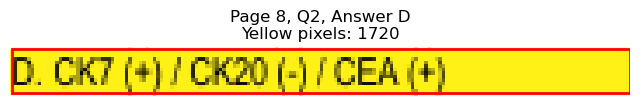


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=141.5, y1=240.9
Page 8, Q3, A: Yellow pixels: 1451
Page 8, Q3, A: Total non-white pixels: 1768
Page 8, Q3, A: Yellow percentage: 82.1%


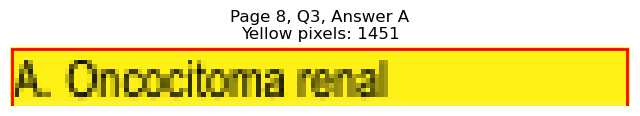

Page 8, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=135.5, y1=253.5
Page 8, Q3, B: Yellow pixels: 130
Page 8, Q3, B: Total non-white pixels: 505
Page 8, Q3, B: Yellow percentage: 25.7%


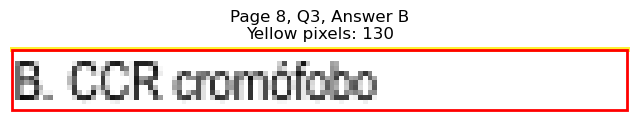

Page 8, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=484.5, y1=240.9
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 850
Page 8, Q3, C: Yellow percentage: 0.0%


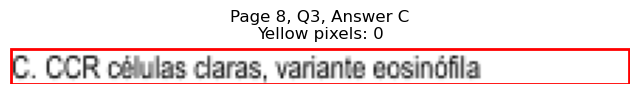

Page 8, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=437.5, y1=253.5
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 629
Page 8, Q3, D: Yellow percentage: 0.0%


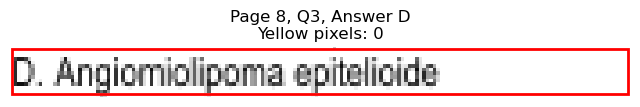


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=152.1, y1=291.4
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 428
Page 8, Q4, A: Yellow percentage: 0.0%


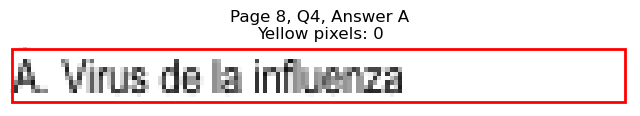

Page 8, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=88.8, y1=304.0
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 145
Page 8, Q4, B: Yellow percentage: 0.0%


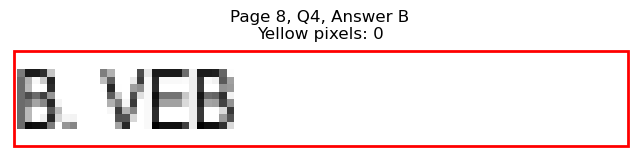

Page 8, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=394.7, y1=291.4
Page 8, Q4, C: Yellow pixels: 1419
Page 8, Q4, C: Total non-white pixels: 1820
Page 8, Q4, C: Yellow percentage: 78.0%


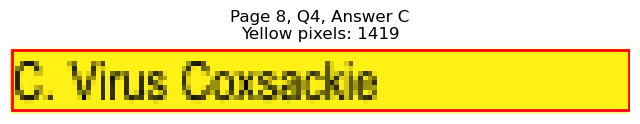

Page 8, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=406.3, y1=304.0
Page 8, Q4, D: Yellow pixels: 142
Page 8, Q4, D: Total non-white pixels: 601
Page 8, Q4, D: Yellow percentage: 23.6%


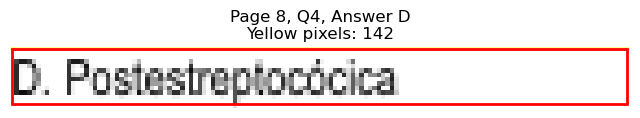


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=167.1, y1=367.2
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 493
Page 8, Q5, A: Yellow percentage: 0.0%


Page 8, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=189.6, y1=379.8
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 677
Page 8, Q5, B: Yellow percentage: 0.0%


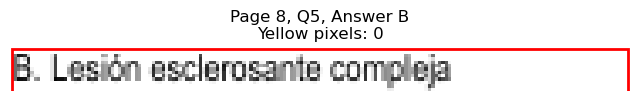

Page 8, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=420.8, y1=367.2
Page 8, Q5, C: Yellow pixels: 1633
Page 8, Q5, C: Total non-white pixels: 2184
Page 8, Q5, C: Yellow percentage: 74.8%


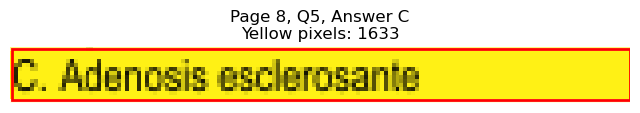

Page 8, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=455.5, y1=379.8
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 866
Page 8, Q5, D: Yellow percentage: 0.0%



Page 8, Q5 - Selected Answer: C (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=127.9, y1=430.3
Page 8, Q6, A: Yellow pixels: 1201
Page 8, Q6, A: Total non-white pixels: 1708
Page 8, Q6, A: Yellow percentage: 70.3%


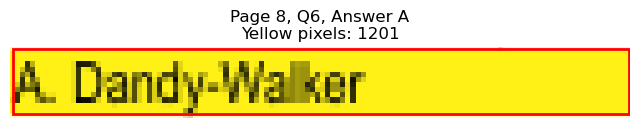

Page 8, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=154.0, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 613
Page 8, Q6, B: Yellow percentage: 0.0%


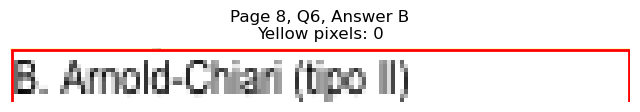

Page 8, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=388.3, y1=430.3
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 325
Page 8, Q6, C: Yellow percentage: 0.0%


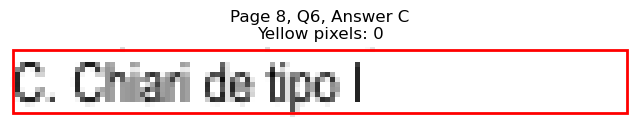

Page 8, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=374.2, y1=442.9
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 264
Page 8, Q6, D: Yellow percentage: 0.0%


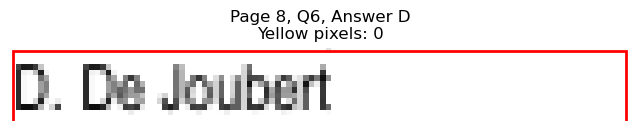


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=184.1, y1=493.4
Page 8, Q7, A: Yellow pixels: 179
Page 8, Q7, A: Total non-white pixels: 780
Page 8, Q7, A: Yellow percentage: 22.9%


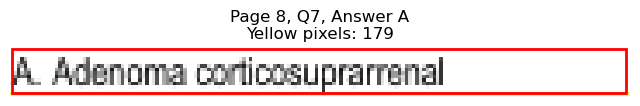

Page 8, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=138.0, y1=506.0
Page 8, Q7, B: Yellow pixels: 1434
Page 8, Q7, B: Total non-white pixels: 1729
Page 8, Q7, B: Yellow percentage: 82.9%


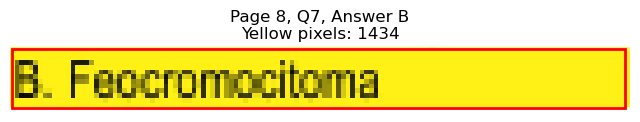

Page 8, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=448.4, y1=493.4
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 634
Page 8, Q7, C: Yellow percentage: 0.0%


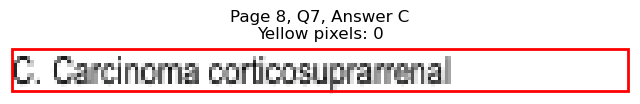

Page 8, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=373.7, y1=506.0
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 277
Page 8, Q7, D: Yellow percentage: 0.0%


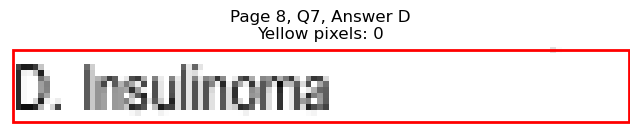


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=245.3, y1=594.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 851
Page 8, Q8, A: Yellow percentage: 0.0%


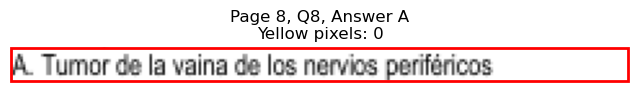

Page 8, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=230.3, y1=606.9
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 850
Page 8, Q8, B: Yellow percentage: 0.0%


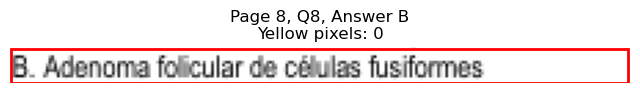

Page 8, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=458.9, y1=594.3
Page 8, Q8, C: Yellow pixels: 194
Page 8, Q8, C: Total non-white pixels: 894
Page 8, Q8, C: Yellow percentage: 21.7%


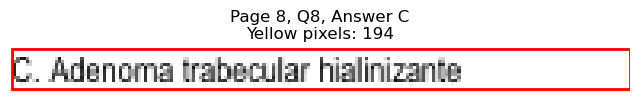

Page 8, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=419.3, y1=606.9
Page 8, Q8, D: Yellow pixels: 1645
Page 8, Q8, D: Total non-white pixels: 2015
Page 8, Q8, D: Yellow percentage: 81.6%


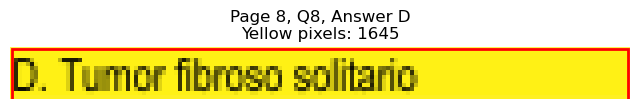


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=89.4, y1=644.9
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 138
Page 8, Q9, A: Yellow percentage: 0.0%


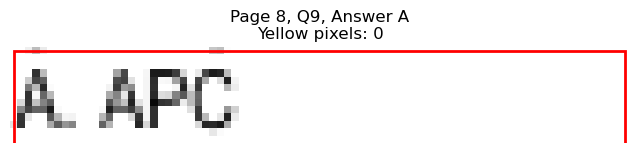

Page 8, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=92.4, y1=657.5
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 167
Page 8, Q9, B: Yellow percentage: 0.0%


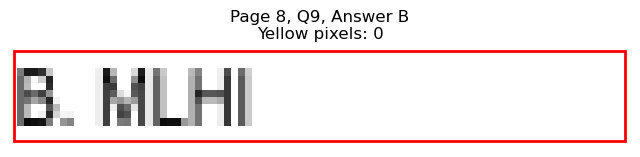

Page 8, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=350.1, y1=644.9
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 227
Page 8, Q9, C: Yellow percentage: 0.0%


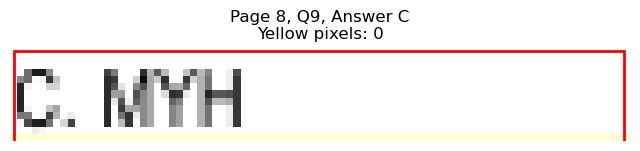

Page 8, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=355.1, y1=657.5
Page 8, Q9, D: Yellow pixels: 1033
Page 8, Q9, D: Total non-white pixels: 1274
Page 8, Q9, D: Yellow percentage: 81.1%


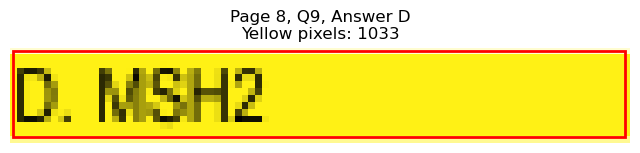


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=119.9, y1=708.0
Page 8, Q10, A: Yellow pixels: 1261
Page 8, Q10, A: Total non-white pixels: 1486
Page 8, Q10, A: Yellow percentage: 84.9%


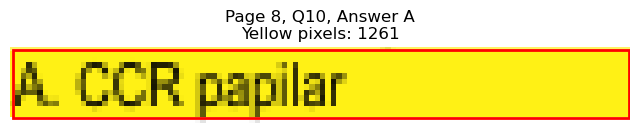

Page 8, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=228.3, y1=720.6
Page 8, Q10, B: Yellow pixels: 219
Page 8, Q10, B: Total non-white pixels: 1033
Page 8, Q10, B: Yellow percentage: 21.2%


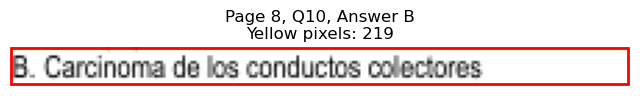

Page 8, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=444.9, y1=708.0
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 614
Page 8, Q10, C: Yellow percentage: 0.0%


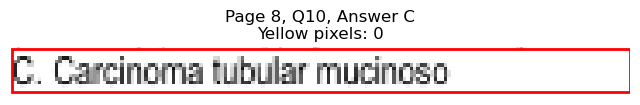

Page 8, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=418.3, y1=720.6
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 481
Page 8, Q10, D: Yellow percentage: 0.0%


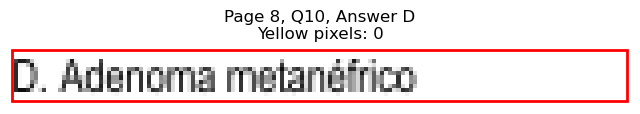


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)

Page 9: Found 12 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=266.9, y1=114.7
Page 9, Q1, A: Yellow pixels: 2606
Page 9, Q1, A: Total non-white pixels: 3393
Page 9, Q1, A: Yellow percentage: 76.8%


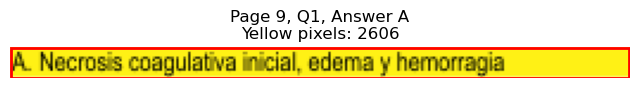

Page 9, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=201.6, y1=127.3
Page 9, Q1, B: Yellow pixels: 193
Page 9, Q1, B: Total non-white pixels: 896
Page 9, Q1, B: Yellow percentage: 21.5%


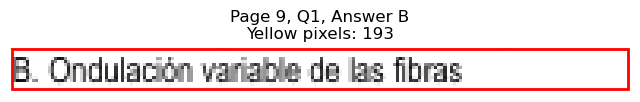

Page 9, Q1 - C: Detected box: x0=56.6, y0=127.2, x1=258.9, y1=139.9
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 1009
Page 9, Q1, C: Yellow percentage: 0.0%


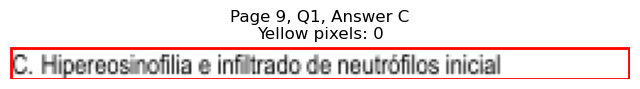

Page 9, Q1 - D: Detected box: x0=56.6, y0=139.9, x1=315.0, y1=152.6
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 1305
Page 9, Q1, D: Yellow percentage: 0.0%


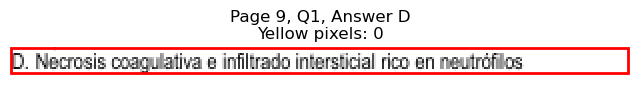


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=184.1, y1=190.4
Page 9, Q2, A: Yellow pixels: 179
Page 9, Q2, A: Total non-white pixels: 787
Page 9, Q2, A: Yellow percentage: 22.7%


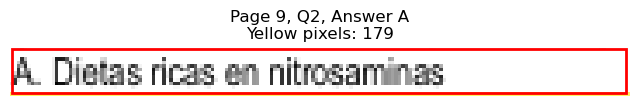

Page 9, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=196.2, y1=203.0
Page 9, Q2, B: Yellow pixels: 1936
Page 9, Q2, B: Total non-white pixels: 2483
Page 9, Q2, B: Yellow percentage: 78.0%


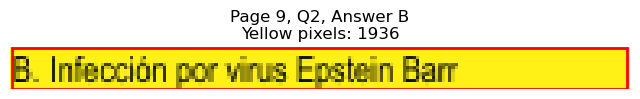

Page 9, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=379.7, y1=190.4
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 302
Page 9, Q2, C: Yellow percentage: 0.0%


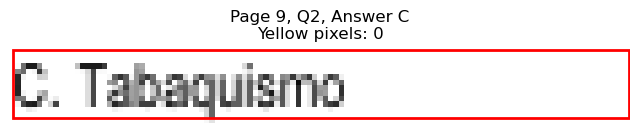

Page 9, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=370.1, y1=203.0
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 275
Page 9, Q2, D: Yellow percentage: 0.0%


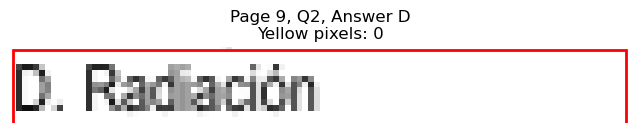


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=137.1, y1=253.5
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 375
Page 9, Q3, A: Yellow percentage: 0.0%


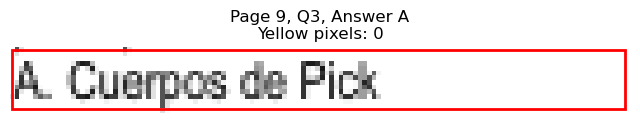

Page 9, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=141.5, y1=266.1
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 418
Page 9, Q3, B: Yellow percentage: 0.0%


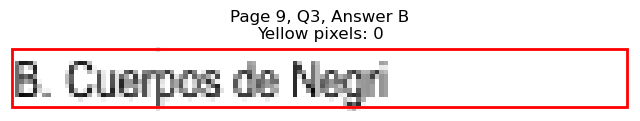

Page 9, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=407.3, y1=253.5
Page 9, Q3, C: Yellow pixels: 143
Page 9, Q3, C: Total non-white pixels: 577
Page 9, Q3, C: Yellow percentage: 24.8%


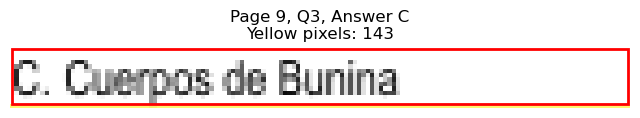

Page 9, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=400.3, y1=266.1
Page 9, Q3, D: Yellow pixels: 1450
Page 9, Q3, D: Total non-white pixels: 1904
Page 9, Q3, D: Yellow percentage: 76.2%


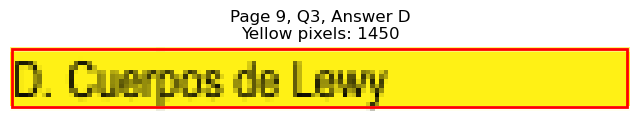


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=112.9, y1=304.0
Page 9, Q4, A: Yellow pixels: 107
Page 9, Q4, A: Total non-white pixels: 375
Page 9, Q4, A: Yellow percentage: 28.5%


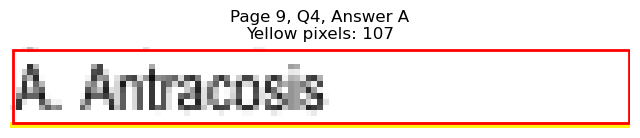

Page 9, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=114.5, y1=316.6
Page 9, Q4, B: Yellow pixels: 1194
Page 9, Q4, B: Total non-white pixels: 1417
Page 9, Q4, B: Yellow percentage: 84.3%


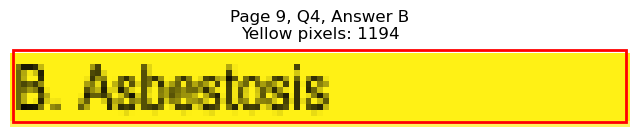

Page 9, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=362.7, y1=304.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 213
Page 9, Q4, C: Yellow percentage: 0.0%


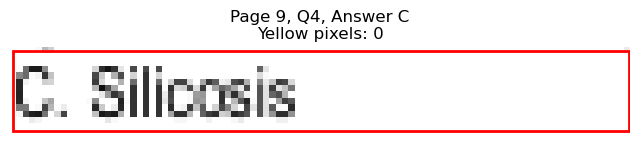

Page 9, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=366.2, y1=316.6
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 238
Page 9, Q4, D: Yellow percentage: 0.0%


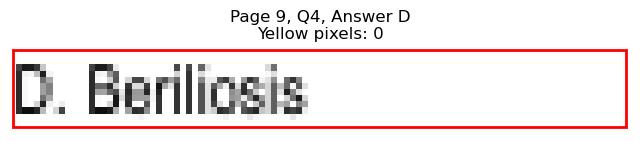


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=149.5, y1=354.6
Page 9, Q5, A: Yellow pixels: 1503
Page 9, Q5, A: Total non-white pixels: 2016
Page 9, Q5, A: Yellow percentage: 74.6%


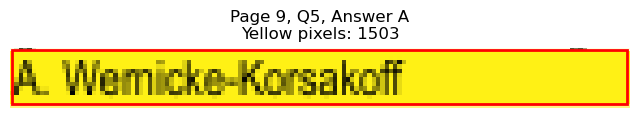

Page 9, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=113.9, y1=367.2
Page 9, Q5, B: Yellow pixels: 108
Page 9, Q5, B: Total non-white pixels: 372
Page 9, Q5, B: Yellow percentage: 29.0%


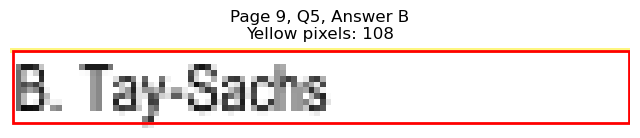

Page 9, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=386.2, y1=354.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 327
Page 9, Q5, C: Yellow percentage: 0.0%


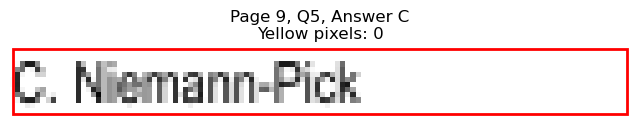

Page 9, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=359.1, y1=367.2
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 189
Page 9, Q5, D: Yellow percentage: 0.0%


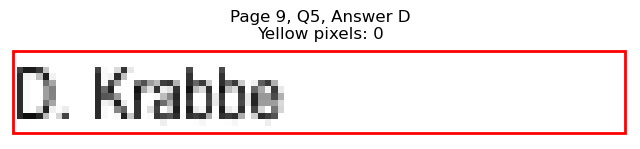


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=194.7, y1=405.0
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 659
Page 9, Q6, A: Yellow percentage: 0.0%


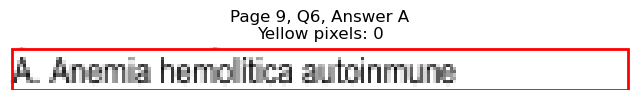

Page 9, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=138.0, y1=417.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 413
Page 9, Q6, B: Yellow percentage: 0.0%


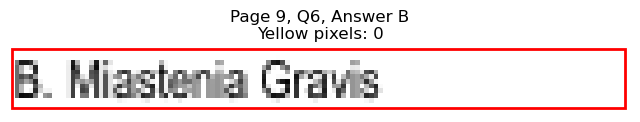

Page 9, Q6 - C: Detected box: x0=315.4, y0=392.3, x1=436.4, y1=405.0
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 764
Page 9, Q6, C: Yellow percentage: 0.0%


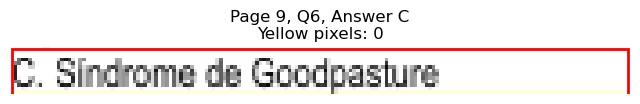

Page 9, Q6 - D: Detected box: x0=315.4, y0=404.9, x1=368.7, y1=417.6
Page 9, Q6, D: Yellow pixels: 1168
Page 9, Q6, D: Total non-white pixels: 1456
Page 9, Q6, D: Yellow percentage: 80.2%


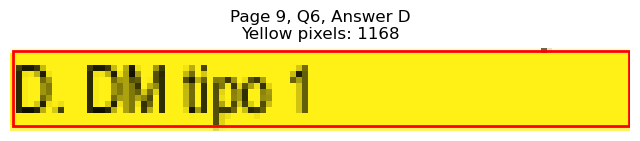


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=455.5, x1=129.0, y1=468.1
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 355
Page 9, Q7, A: Yellow percentage: 0.0%


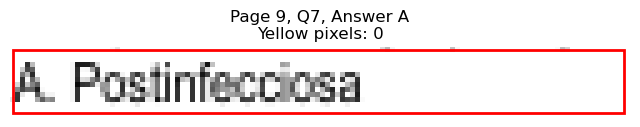

Page 9, Q7 - B: Detected box: x0=56.6, y0=468.1, x1=160.6, y1=480.7
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 504
Page 9, Q7, B: Yellow percentage: 0.0%


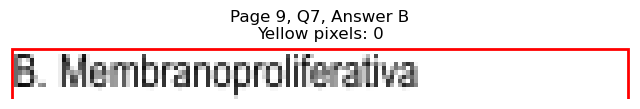

Page 9, Q7 - C: Detected box: x0=315.4, y0=455.5, x1=382.7, y1=468.1
Page 9, Q7, C: Yellow pixels: 1285
Page 9, Q7, C: Total non-white pixels: 1652
Page 9, Q7, C: Yellow percentage: 77.8%


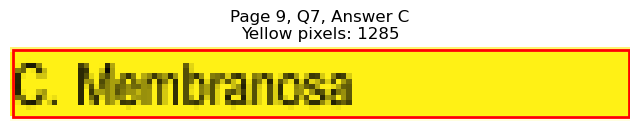

Page 9, Q7 - D: Detected box: x0=315.4, y0=468.1, x1=428.3, y1=480.7
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 753
Page 9, Q7, D: Yellow percentage: 0.0%


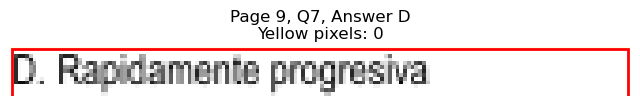


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=506.0, x1=112.5, y1=518.6
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 277
Page 9, Q8, A: Yellow percentage: 0.0%


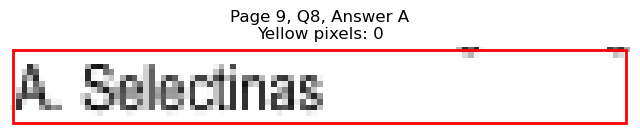

Page 9, Q8 - B: Detected box: x0=56.6, y0=518.6, x1=113.9, y1=531.2
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 284
Page 9, Q8, B: Yellow percentage: 0.0%


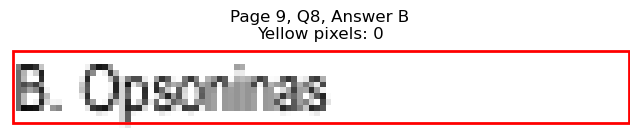

Page 9, Q8 - C: Detected box: x0=315.4, y0=506.0, x1=369.7, y1=518.6
Page 9, Q8, C: Yellow pixels: 1169
Page 9, Q8, C: Total non-white pixels: 1470
Page 9, Q8, C: Yellow percentage: 79.5%


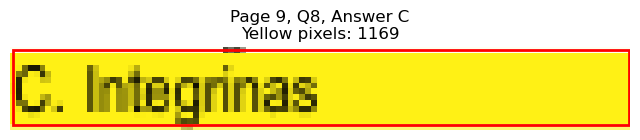

Page 9, Q8 - D: Detected box: x0=315.4, y0=518.6, x1=400.3, y1=531.2
Page 9, Q8, D: Yellow pixels: 134
Page 9, Q8, D: Total non-white pixels: 519
Page 9, Q8, D: Yellow percentage: 25.8%


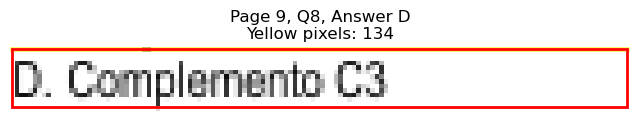


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=556.5, x1=171.1, y1=569.1
Page 9, Q9, A: Yellow pixels: 166
Page 9, Q9, A: Total non-white pixels: 708
Page 9, Q9, A: Yellow percentage: 23.4%


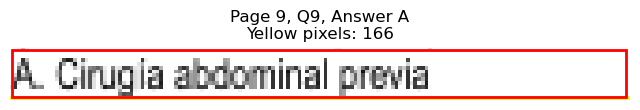

Page 9, Q9 - B: Detected box: x0=56.6, y0=569.1, x1=226.8, y1=581.7
Page 9, Q9, B: Yellow pixels: 2207
Page 9, Q9, B: Total non-white pixels: 2873
Page 9, Q9, B: Yellow percentage: 76.8%


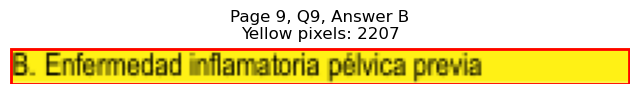

Page 9, Q9 - C: Detected box: x0=315.4, y0=556.5, x1=387.2, y1=569.1
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 333
Page 9, Q9, C: Yellow percentage: 0.0%


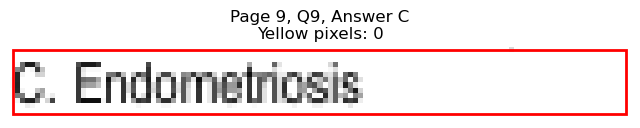

Page 9, Q9 - D: Detected box: x0=315.4, y0=569.1, x1=459.9, y1=581.7
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 726
Page 9, Q9, D: Yellow percentage: 0.0%


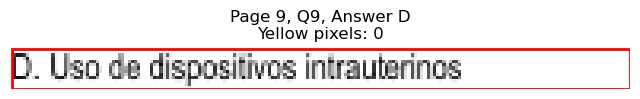


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=606.9, x1=188.7, y1=619.5
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 619
Page 9, Q10, A: Yellow percentage: 0.0%


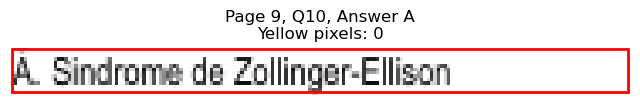

Page 9, Q10 - B: Detected box: x0=56.6, y0=619.6, x1=127.9, y1=632.3
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 343
Page 9, Q10, B: Yellow percentage: 0.0%


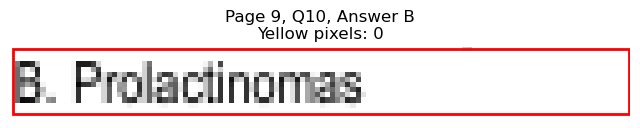

Page 9, Q10 - C: Detected box: x0=315.4, y0=606.9, x1=443.3, y1=619.5
Page 9, Q10, C: Yellow pixels: 1818
Page 9, Q10, C: Total non-white pixels: 2506
Page 9, Q10, C: Yellow percentage: 72.5%


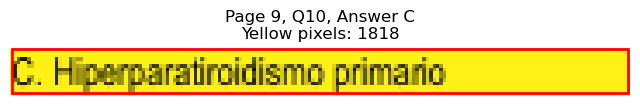

Page 9, Q10 - D: Detected box: x0=315.4, y0=619.6, x1=381.2, y1=632.3
Page 9, Q10, D: Yellow pixels: 117
Page 9, Q10, D: Total non-white pixels: 421
Page 9, Q10, D: Yellow percentage: 27.8%


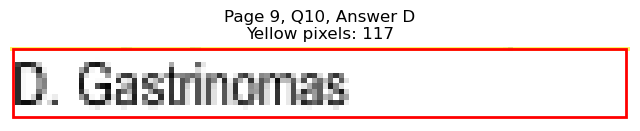


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)
Page 9, Q11 - A: Detected box: x0=56.6, y0=657.4, x1=124.0, y1=670.1
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 313
Page 9, Q11, A: Yellow percentage: 0.0%


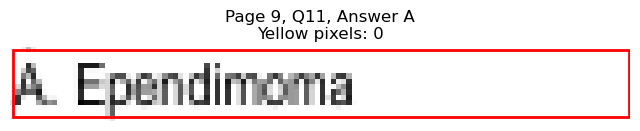

Page 9, Q11 - B: Detected box: x0=56.6, y0=670.0, x1=118.5, y1=682.7
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 309
Page 9, Q11, B: Yellow percentage: 0.0%


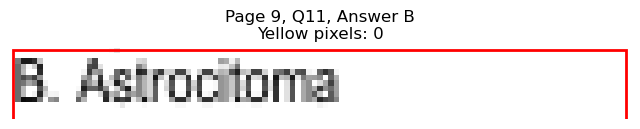

Page 9, Q11 - C: Detected box: x0=315.4, y0=657.4, x1=396.3, y1=670.1
Page 9, Q11, C: Yellow pixels: 1377
Page 9, Q11, C: Total non-white pixels: 1848
Page 9, Q11, C: Yellow percentage: 74.5%


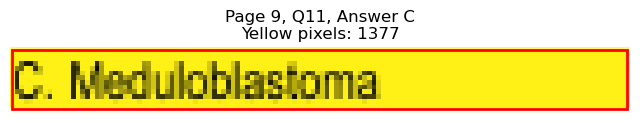

Page 9, Q11 - D: Detected box: x0=315.4, y0=670.0, x1=408.3, y1=682.7
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 599
Page 9, Q11, D: Yellow percentage: 0.0%


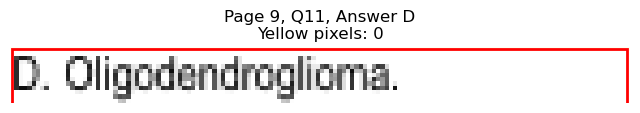


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)
Page 9, Q12 - A: Detected box: x0=56.6, y0=720.6, x1=121.0, y1=733.2
Page 9, Q12, A: Yellow pixels: 1260
Page 9, Q12, A: Total non-white pixels: 1610
Page 9, Q12, A: Yellow percentage: 78.3%


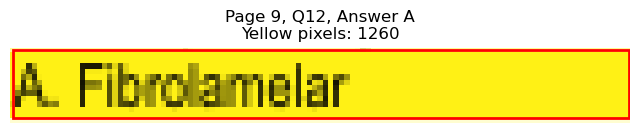

Page 9, Q12 - B: Detected box: x0=56.6, y0=733.2, x1=98.9, y1=745.8
Page 9, Q12, B: Yellow pixels: 0
Page 9, Q12, B: Total non-white pixels: 273
Page 9, Q12, B: Yellow percentage: 0.0%


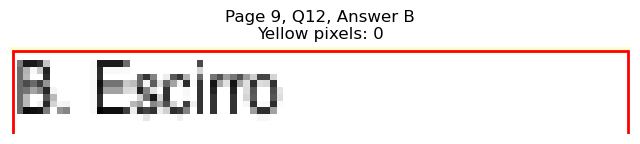

Page 9, Q12 - C: Detected box: x0=315.4, y0=720.6, x1=385.7, y1=733.2
Page 9, Q12, C: Yellow pixels: 0
Page 9, Q12, C: Total non-white pixels: 346
Page 9, Q12, C: Yellow percentage: 0.0%


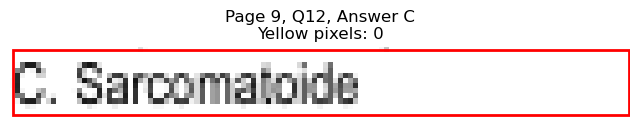

Page 9, Q12 - D: Detected box: x0=315.4, y0=733.2, x1=387.8, y1=745.8
Page 9, Q12, D: Yellow pixels: 0
Page 9, Q12, D: Total non-white pixels: 366
Page 9, Q12, D: Yellow percentage: 0.0%


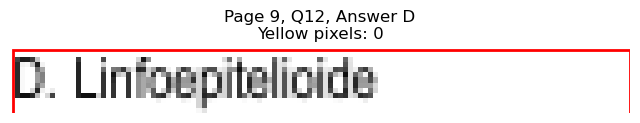


Page 9, Q12 - Selected Answer: A (based on yellow pixel count)

Page 10: Found 6 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=94.3, y1=102.1
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 144
Page 10, Q1, A: Yellow percentage: 0.0%


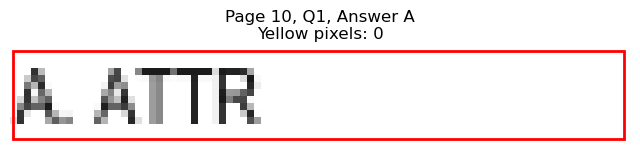

Page 10, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=81.9, y1=114.7
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 115
Page 10, Q1, B: Yellow percentage: 0.0%


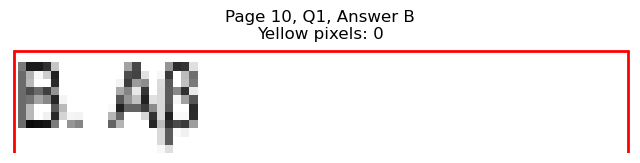

Page 10, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=353.7, y1=102.1
Page 10, Q1, C: Yellow pixels: 1035
Page 10, Q1, C: Total non-white pixels: 1246
Page 10, Q1, C: Yellow percentage: 83.1%


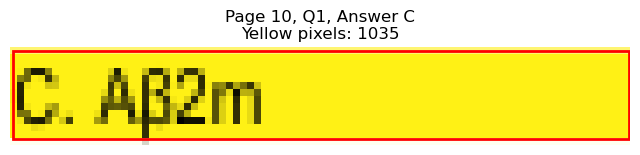

Page 10, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=342.1, y1=114.7
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 178
Page 10, Q1, D: Yellow percentage: 0.0%


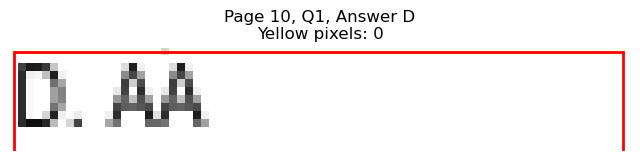


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=183.1, y1=165.2
Page 10, Q2, A: Yellow pixels: 178
Page 10, Q2, A: Total non-white pixels: 790
Page 10, Q2, A: Yellow percentage: 22.5%


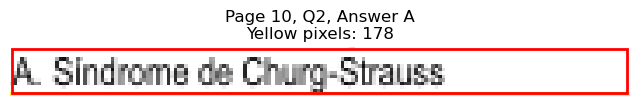

Page 10, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=178.1, y1=177.8
Page 10, Q2, B: Yellow pixels: 1779
Page 10, Q2, B: Total non-white pixels: 2249
Page 10, Q2, B: Yellow percentage: 79.1%


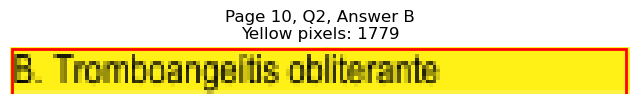

Page 10, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=436.9, y1=165.2
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 595
Page 10, Q2, C: Yellow percentage: 0.0%


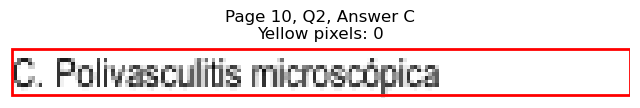

Page 10, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=432.9, y1=177.8
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 567
Page 10, Q2, D: Yellow percentage: 0.0%


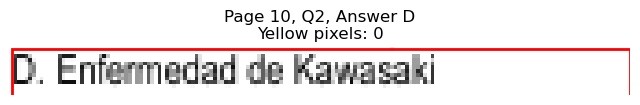


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=221.7, y1=240.9
Page 10, Q3, A: Yellow pixels: 2155
Page 10, Q3, A: Total non-white pixels: 2808
Page 10, Q3, A: Yellow percentage: 76.7%


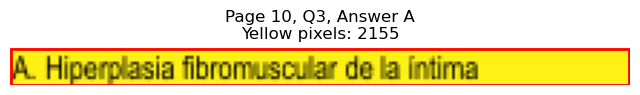

Page 10, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=144.5, y1=253.5
Page 10, Q3, B: Yellow pixels: 136
Page 10, Q3, B: Total non-white pixels: 588
Page 10, Q3, B: Yellow percentage: 23.1%


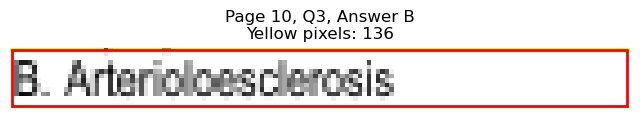

Page 10, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=485.0, y1=240.9
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 836
Page 10, Q3, C: Yellow percentage: 0.0%


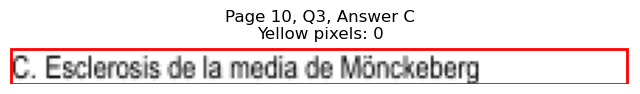

Page 10, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=391.7, y1=253.5
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 380
Page 10, Q3, D: Yellow percentage: 0.0%



Page 10, Q3 - Selected Answer: A (based on yellow pixel count)
Page 10, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=107.4, y1=291.4
Page 10, Q4, A: Yellow pixels: 102
Page 10, Q4, A: Total non-white pixels: 342
Page 10, Q4, A: Yellow percentage: 29.8%


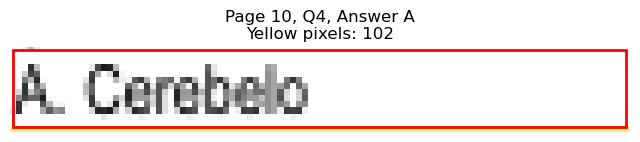

Page 10, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=140.1, y1=304.0
Page 10, Q4, B: Yellow pixels: 1437
Page 10, Q4, B: Total non-white pixels: 1890
Page 10, Q4, B: Yellow percentage: 76.0%


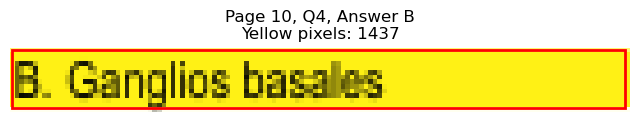

Page 10, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=386.2, y1=291.4
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 347
Page 10, Q4, C: Yellow percentage: 0.0%


Page 10, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=384.8, y1=304.0
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 314
Page 10, Q4, D: Yellow percentage: 0.0%


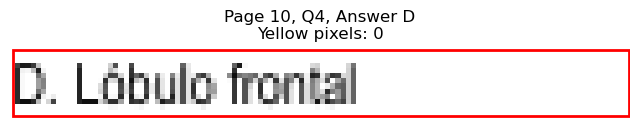


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)
Page 10, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=139.0, y1=367.2
Page 10, Q5, A: Yellow pixels: 133
Page 10, Q5, A: Total non-white pixels: 532
Page 10, Q5, A: Yellow percentage: 25.0%


Page 10, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=216.3, y1=379.8
Page 10, Q5, B: Yellow pixels: 2136
Page 10, Q5, B: Total non-white pixels: 2743
Page 10, Q5, B: Yellow percentage: 77.9%


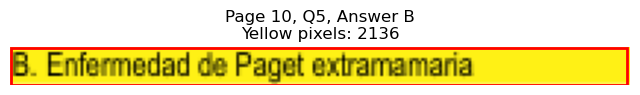

Page 10, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=413.8, y1=367.2
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 508
Page 10, Q5, C: Yellow percentage: 0.0%


Page 10, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=447.4, y1=379.8
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 699
Page 10, Q5, D: Yellow percentage: 0.0%


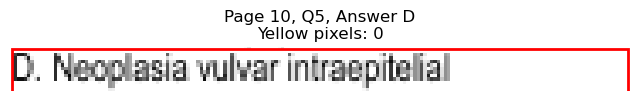


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)
Page 10, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=131.5, y1=442.9
Page 10, Q6, A: Yellow pixels: 1353
Page 10, Q6, A: Total non-white pixels: 1638
Page 10, Q6, A: Yellow percentage: 82.6%


Page 10, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=124.9, y1=455.5
Page 10, Q6, B: Yellow pixels: 117
Page 10, Q6, B: Total non-white pixels: 467
Page 10, Q6, B: Yellow percentage: 25.1%


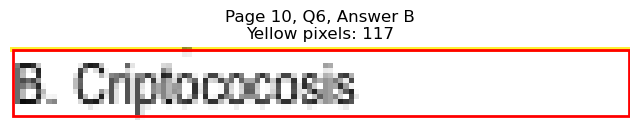

Page 10, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=385.3, y1=442.9
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 331
Page 10, Q6, C: Yellow percentage: 0.0%


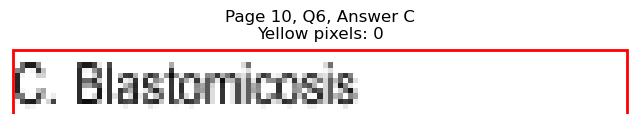

Page 10, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=423.8, y1=455.5
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 544
Page 10, Q6, D: Yellow percentage: 0.0%



Page 10, Q6 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es el protozoo causante de la enfermedad...
1   Linfoma insidioso más frecuente en adultos, co...
2   Varón de 36 años, con lesión localizada en zon...
3   ¿Qué tipo de linfocitos originan el síndrome d...
4   ¿Qué lóbulos cerebrales son afectados en la en...
..                                                ...
95  Los hallazgos microscópicos, de una arteria pe...
96  De los siguientes patrones de arterioesclerosi...
97  ¿Cuál es la localización más frecuente de la h...
98  Mujer de 50 años con lesión pruriginosa, roja ...
99  Varón de 30 años, con historia de tos producti...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                          option_B  \
0                    Entamoeba histolytica               Leishmania donovani   
1              B difuso de células grandes                         Folicular   
2                            Ameloblastoma             Fibroma ameloblástico   
3                            T colaborador                      T citotóxico   
4                     Temporal y occipital              Parietal y occipital   
..                                     ...                               ...   
95               Síndrome de Churg-Strauss        Tromboangeítis obliterante   
96  Hiperplasia fibromuscular de la íntima               Arterioloesclerosis   
97                                Cerebelo                  Ganglios basales   
98                        Melanoma in situ  Enfermedad de Paget extramamaria   
99                          Histoplasmosis                     Criptococosis   

                                option_C                         option_D  
0                      Naegleria fowleri                Trypanosoma cruzi  
1                    Linfocítico pequeño                       De Burkitt  
2            Fibroodontoma ameloblástico    Tumor odontógeno adenomatoide  
3                              B memoria                         B virgen  
4                    Frontal y occipital              Parietal y temporal  
..                                   ...                              ...  
95           Polivasculitis microscópica           Enfermedad de Kawasaki  
96  Esclerosis de la media de Mönckeberg                  Ateroesclerosis  
97                         Protuberancia                   Lóbulo frontal  
98                   Hidradenoma papilar  Neoplasia vulvar intraepitelial  
99                         Blastomicosis           Paracoccidioidomicosis  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cuál es el protozoo causante de la enfermedad...   
1   Linfoma insidioso más frecuente en adultos, co...   
2   Varón de 36 años, con lesión localizada en zon...   
3   ¿Qué tipo de linfocitos originan el síndrome d...   
4   ¿Qué lóbulos cerebrales son afectados en la en...   
..                                                ...   
95  Los hallazgos microscópicos, de una arteria pe...   
96  De los siguientes patrones de arterioesclerosi...   
97  ¿Cuál es la localización más frecuente de la h...   
98  Mujer de 50 años con lesión pruriginosa, roja ...   
99  Varón de 30 años, con historia de tos producti...   

                                  option_A                          option_B  \
0                    Entamoeba histolytica               Leishmania donovani   
1              B difuso de células grandes                         Folicular   
2                            Ameloblastoma             Fibroma ameloblástico   
3                            T colaborador                      T citotóxico   
4                     Temporal y occipital              Parietal y occipital   
..                                     ...                               ...   
95               Síndrome de Churg-Strauss        Tromboangeítis obliterante   
96  Hiperplasia fibromuscular de la íntima               Arterioloesclerosis   
97                                Cerebelo                  Ganglios basales   
98                        Melanoma in situ  Enfermedad de Paget extramamaria   
99                          Histoplasmosis                     Criptococosis   

                                option_C                         option_D  \
0                      Naegleria fowleri                Trypanosoma cruzi   
1                    Linfocítico pequeño                       De Burkitt   
2            Fibroodontoma ameloblástico    Tumor odontógeno adenomatoide   
3                              B memoria                         B virgen   
4                    Frontal y occipital              Parietal y temporal   
..                                   ...                              ...   
95           Polivasculitis microscópica           Enfermedad de Kawasaki   
96  Esclerosis de la media de Mönckeberg                  Ateroesclerosis   
97                         Protuberancia                   Lóbulo frontal   
98                   Hidradenoma papilar  Neoplasia vulvar intraepitelial   
99                         Blastomicosis           Paracoccidioidomicosis   

   correct_answer  
0               B  
1               B  
2               A  
3               A  
4               D  
..            ...  
95              B  
96              A  
97              B  
98              B  
99              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ANATOMÍA PATOLÓGICA.csv
